 # <center> KPMG - Data Science Technical Assignment </center>

The below notebook explores internet usage over time and geography within the Trentino region of Italy. The work within this notebook does some exploratory analysis into the internet usage dataset before performing clustering analysis across the time series data to get a deeper understanding of the different regions of Trentino. The clusters from this analysis are then mapped onto the geospacial data, creating .geojson files that can be viewed in [github](https://github.com/natalie-stephenson/GeoJson)

# Internet Activity Data Set

## Initial Data Exploration


Firstly, I'll take a look to ensure the data looks as expected and the data types are correct. I'll then do some initial exploring to look at the size and profile of the data. 

In [2]:
import pandas as pd

InternetUsage = pd.read_csv("2_Telecommunications_Internet/Internet_traffic_activity.csv", header=None)
InternetUsage.columns = ['GRID', 'DateTime', 'InternetActivity']
print(InternetUsage)

          GRID          DateTime  InternetActivity
0        10000  2013-12-01 00:00          9.381368
1        10000  2013-12-01 01:00         11.966050
2        10000  2013-12-01 02:00         10.588980
3        10000  2013-12-01 03:00          8.662089
4        10000  2013-12-01 04:00          7.491499
...        ...               ...               ...
9292833   9999  2013-12-31 19:00         33.811344
9292834   9999  2013-12-31 20:00         32.427682
9292835   9999  2013-12-31 21:00         34.441008
9292836   9999  2013-12-31 22:00         32.575771
9292837   9999  2013-12-31 23:00         29.968917

[9292838 rows x 3 columns]


In [3]:
InternetUsage.dtypes

GRID                  int64
DateTime             object
InternetActivity    float64
dtype: object

In [4]:
InternetUsage['DateTime'] = pd.to_datetime(InternetUsage['DateTime'])
InternetUsage.dtypes

GRID                         int64
DateTime            datetime64[ns]
InternetActivity           float64
dtype: object

In [5]:
InternetUsage['InternetActivity'].describe()

count    9.291226e+06
mean     1.663374e+01
std      4.433642e+01
min      5.836761e-06
25%      2.867392e+00
50%      7.646948e+00
75%      1.738772e+01
max      3.878055e+03
Name: InternetActivity, dtype: float64

Immediately I can see that there is a wide spread of values for Internet Activity with the max of the data being orders of manitude higher than the mean. 

In [277]:
#InternetUsage.GRID.nunique()

6259

I first just want to look at the data over time to see what this data looks like. 

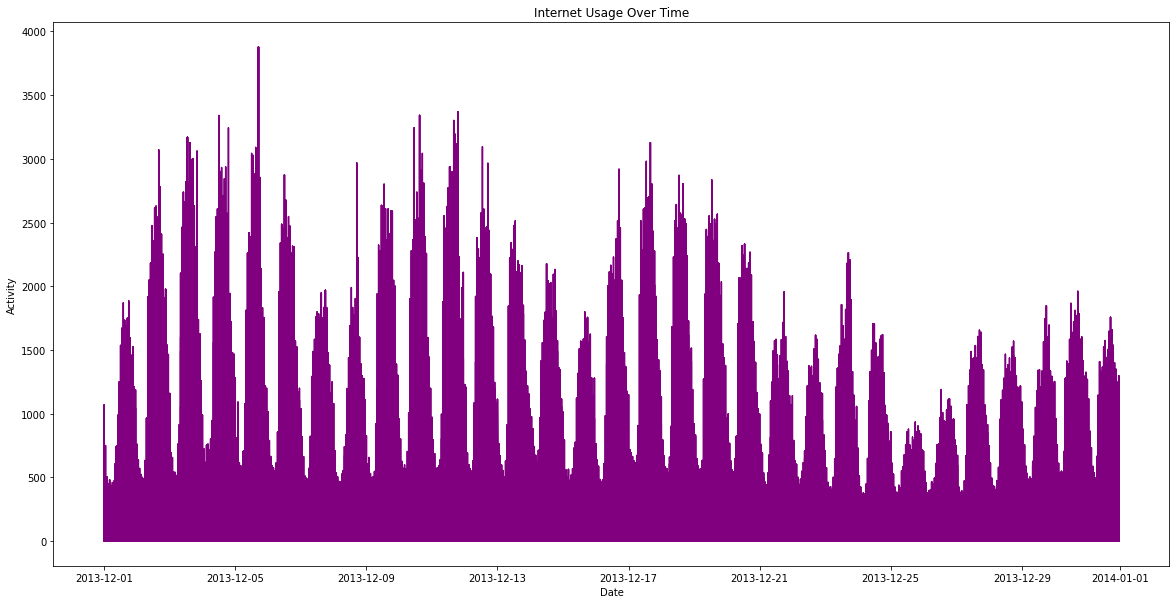

In [8]:
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rcParams['agg.path.chunksize'] = 10000

df = InternetUsage
df = df.set_index('DateTime')
df = df.sort_index()

# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 10))

# Add x-axis and y-axis
ax.plot(df.index.values,
        df['InternetActivity'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Activity",
       title="Internet Usage Over Time")

plt.show()

As there are a large number of data points for each time perdiod, it's difficult to interpret the data in a meaningful way. 

As such, some data manipulation will be explored to look into ways to more easily interpret trends in this data. 
Firstly, I'll take a look at aggregating data for all the GRIDs at each time point to look at trends over time. 


In [9]:
df_grouped = df.groupby('DateTime').agg({'InternetActivity': ['mean', 'min', 'max']}) 
df_grouped

InternetActivity                       
                                mean       min          max
DateTime                                                   
2013-12-01 00:00:00        13.023135  0.000021  1070.279598
2013-12-01 01:00:00        10.710367  0.000021   749.505747
2013-12-01 02:00:00         9.007488  0.000021   503.577524
2013-12-01 03:00:00         7.786636  0.000106   449.290946
2013-12-01 04:00:00         7.334134  0.000021   479.709572
...                              ...       ...          ...
2013-12-31 19:00:00        33.532842  0.000168  1536.899200
2013-12-31 20:00:00        33.406863  0.000430  1399.242415
2013-12-31 21:00:00        30.634212  0.000430  1347.564298
2013-12-31 22:00:00        29.519743  0.000381  1246.209553
2013-12-31 23:00:00        29.338079  0.000478  1297.763276

[744 rows x 3 columns]

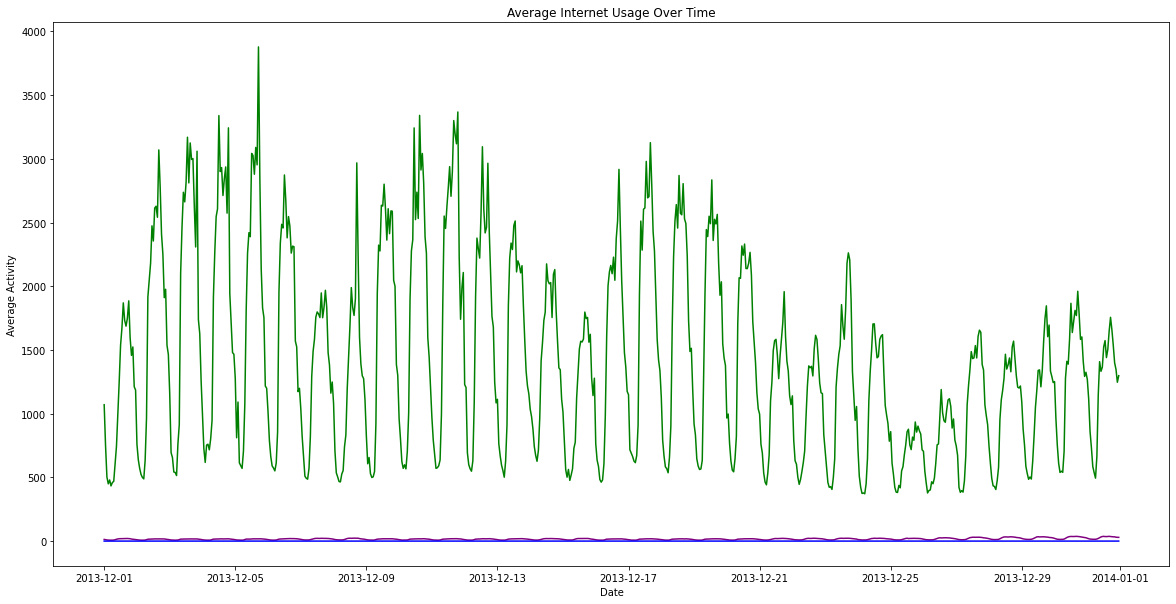

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_grouped.index.values,
        df_grouped['InternetActivity']['mean'],
        color='purple')

ax.plot(df_grouped.index.values,
        df_grouped['InternetActivity']['min'],
        color='blue')

ax.plot(df_grouped.index.values,
        df_grouped['InternetActivity']['max'],
        color='green')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Average Activity",
       title="Average Internet Usage Over Time")

plt.show()

Again, the difference between the mean and max of this data tells me the data is very skewed. 

As the max is preventing me from observing any trends across the other aggregations, these graphs will be split into seperate graphs. 

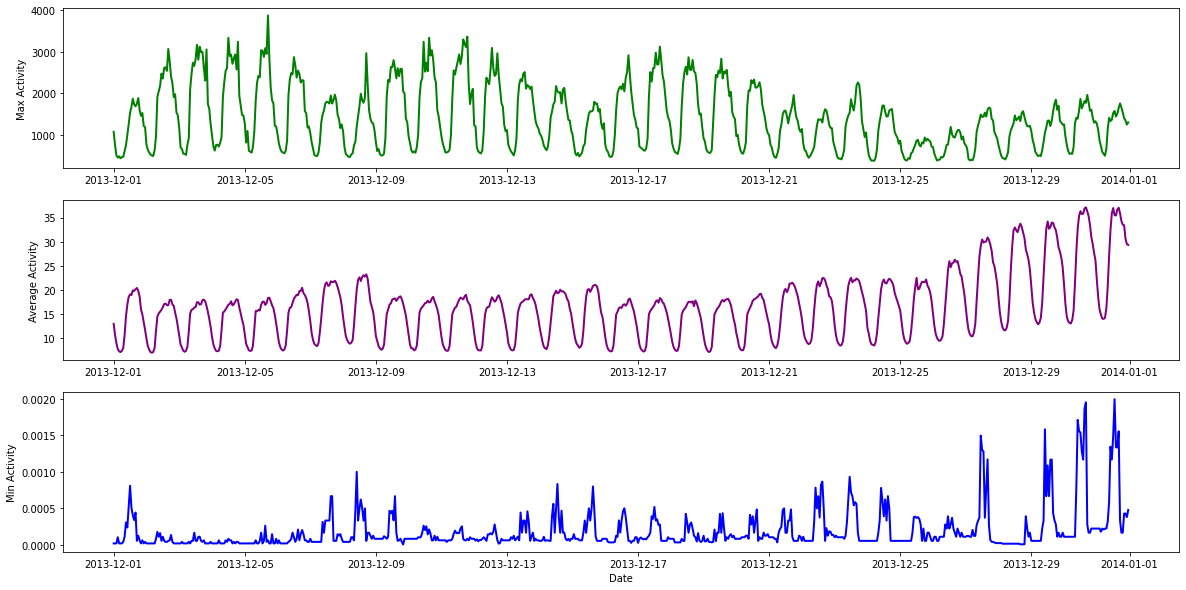

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(df_grouped.index.values,
        df_grouped['InternetActivity']['max'],
        color='green',
        linewidth= 2)
plt.ylabel("Max Activity")


plt.subplot(3, 1, 2)

plt.plot(df_grouped.index.values,
        df_grouped['InternetActivity']['mean'],
        color='purple',
        linewidth= 2)
plt.ylabel("Average Activity")

plt.subplot(3, 1, 3)

plt.plot(df_grouped.index.values,
        df_grouped['InternetActivity']['min'],
        color='blue',
        linewidth= 2)
plt.ylabel("Min Activity")


plt.xlabel("Date")
plt.show()

There's a really lovely daily trend visible in this data - where you can see peak usage occuring over the daylight hours, with this dropping off overnight. 

There looks like there might be a slight trend over the period of a week, as there looks to be 2 days out of 7 where internet activity is slightly elevated - although further investigation of this will be required. 

Finally, there are interesting changes to these aggregations over the holiday trends. Whilst average and minimum activity increases, perhaps due to increased leisure time over the Christmas holiday perioid, there is a decrease in max activity. This may suggest that businesses across the Trentino region are responsible for higher internet usage. As a number of these businesses will be closing or reducing their hours over the Christmas period, this could result in a reduction in the maximum value observed.  

I'll look to explore different spacial trends in a little more detail later in this notebook. 

First, I'd like to take a look a little more into the spread of the data, and the degree of skew on the mean. 

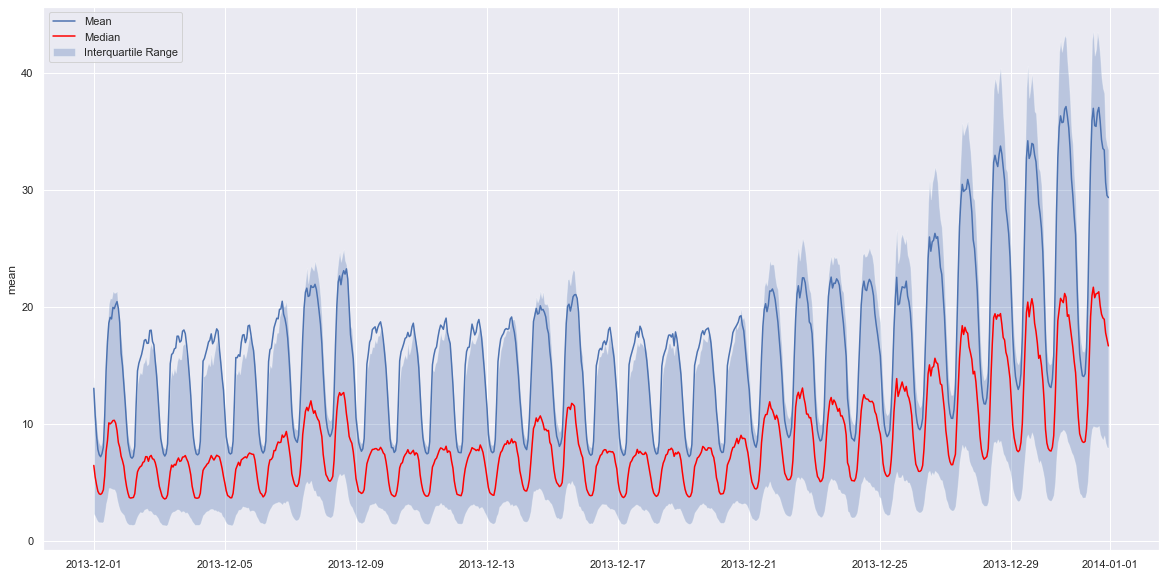

In [12]:
import seaborn as sns; sns.set()


fig, ax = plt.subplots(figsize=(20, 10))

df_iqr_lower = df.groupby('DateTime').InternetActivity.quantile(0.25) 
df_iqr_upper = df.groupby('DateTime').InternetActivity.quantile(0.75)
df_median = df.groupby('DateTime').InternetActivity.median()
df_grouped['IQRLower'] = df_iqr_lower
df_grouped['IQRUpper'] = df_iqr_upper
df_grouped['Median'] = df_median

ax = sns.lineplot(df_grouped.index.values, df_grouped['InternetActivity']['mean'], label='Mean') 
ax = sns.lineplot(df_grouped.index.values, df_grouped['Median'], color = 'red', label='Median') 
ax.fill_between(df_grouped.index.values, df_grouped['IQRLower'], df_grouped['IQRUpper'], alpha=0.3, label='Interquartile Range')
plt.legend(loc='upper left')

We can see from this graph that the mean is significantly higher than the median and regularly falls above 75% of the data, suggesting significant skew of the data. I'd like to take a slice of this data at a single timepoint and view a histogram of this data, to get a clear picture of the skewness. 

In [13]:
timepointcount = df.groupby('DateTime').count()
timepointcount.InternetActivity.sort_values(ascending=False)
timepointcount

GRID  InternetActivity
DateTime                                    
2013-12-01 00:00:00  12472             12472
2013-12-01 01:00:00  12474             12474
2013-12-01 02:00:00  12470             12470
2013-12-01 03:00:00  12432             12432
2013-12-01 04:00:00  12436             12436
...                    ...               ...
2013-12-31 19:00:00  12516             12514
2013-12-31 20:00:00  12514             12514
2013-12-31 21:00:00  12514             12514
2013-12-31 22:00:00  12514             12514
2013-12-31 23:00:00  12516             12514

[744 rows x 2 columns]

As there is a full data set for 2013-12-01 12:00:00, I'll take a look at a histogram of this data, to take a closer look at the skew in the data.

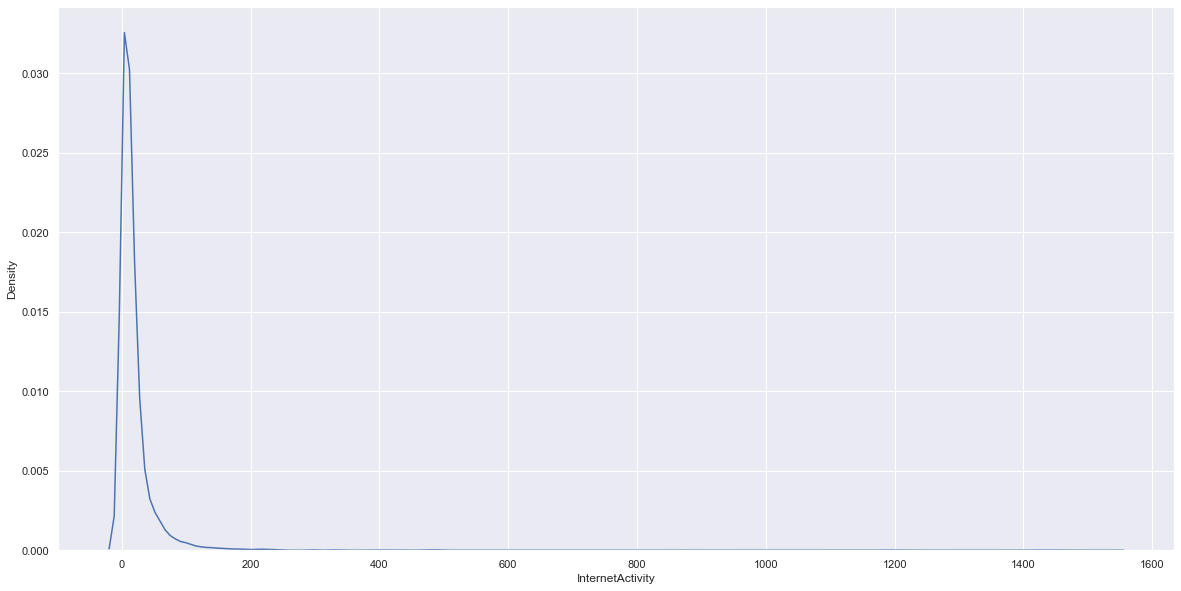

In [14]:
df_indexed = df.reset_index()
df_singletimepoint =  df_indexed[(df_indexed['DateTime']=='2013-12-01 12:00:00')]

fig, ax = plt.subplots(figsize=(20, 10))
hist = sns.distplot(df_singletimepoint['InternetActivity'], hist=False, color='b')
plt.show()

The skew of internet usage is more pronounced than I was expecting, although perhaps I should have expected this. The Italian province of Trentino covers >65 km<sup>2</sup> km and has a population of over 500,000 people. The diverse socio-economic profile of the regions and municipalities that make up this province are likely to affect the level of intenet usage. Additionally, grids that fall within business areas will have different levels and patterns of internet usage to those that fall into residential regions.    

The GRID provides us with spacial data so it would be interesting to see if we could perform clustering on this temporal data, to identify clusters with similar temporal patterns.

As I'm relatively new to working with temporal data, I had a look into methods that I could use to perform unsupervised clustering on time-series data. Here is what I found:

- **Discrete Fourier Transform** - this offers an option to break the time series data into the key components of it's periodicity, looking at the frequencies of the curve, this would then require the use of PCA to reduce the dimensionality of the data. Clustering would be performed on the PCA scores of this data.
- **Euclidean Distance** - When comparing two time-seiries, the Euclidean distance is the difference between values for time point in the series. This pairwise comparison can be performed before clustering to look at clusters based on their relative distance from each other. 
- **Dynamic Time Warping** - This uses the Euclidean Distance, however, instead of comparing the two sets of values at t=0, then t=1 and so on, it compares the distances at all time points in series 1, to all time points in series 2 to align them optimally, finding the minimum Euclidean Distance between each sequence. This generally improves upon the Euclidean distance measure for time series data, in cases where you have ofsets to account for, and is a popular method of choice for analysis of time series data. However, this option is very compute heavy for a time-boxed piece of work, and as initial analysis showed strong periodicity and alignment in the sequences, I feel Euclidean Distance alone will suffice in this case. 
- **Telescope Distance** - This instead compares the timeseries as probability distributions, which can return values the can be used in a binary classifier. Although this has been shown to outperform DTW in table 1 of [this paper](https://www.jmlr.org/papers/volume14/ryabko13a/ryabko13a.pdf), I feel a stronger understanding of the underlying mathematical process is required for me to full interrogate this method.

From this research, I'd like to look at two approaches to cluster this data. Firstly, I'll look at using Discrete Fourier Transforms of the timeseries data, and using PCA to reduce the dimensionality of the data before using this for kMeans clustering analysis. I'd then like to use Euclidean Distance as part of a Time Series kMeans Clustering analysis. 


## Data Cleansing
Before I begin prepping the data for these approaches, I need to investigate the data for duplicates and null values, and begin adjusting for this in the data.

In [15]:
InternetUsage['InternetActivity'].sort_values()

5879031    0.000006
1232612    0.000006
4114680    0.000009
4114681    0.000009
8761100    0.000009
             ...   
9228629         NaN
9228631         NaN
9228635         NaN
9253902         NaN
9253903         NaN
Name: InternetActivity, Length: 9292838, dtype: float64

In [16]:
Staged = InternetUsage

In [17]:
Staged['InternetActivity'].sort_values()

5879031    0.000006
1232612    0.000006
4114680    0.000009
4114681    0.000009
8761100    0.000009
             ...   
9228629         NaN
9228631         NaN
9228635         NaN
9253902         NaN
9253903         NaN
Name: InternetActivity, Length: 9292838, dtype: float64

In [278]:
Staged.groupby(['DateTime','GRID'])['InternetActivity'].count()

DateTime             GRID 
2013-12-01 00:00:00  38       2
                     39       2
                     40       2
                     154      2
                     155      2
                     156      2
                     157      2
                     158      2
                     159      2
                     160      2
                             ..
2013-12-31 23:00:00  11217    2
                     11218    2
                     11219    2
                     11220    2
                     11335    2
                     11336    2
                     11337    2
                     11452    2
                     11453    2
                     11454    2
Name: InternetActivity, Length: 4646419, dtype: int64

In [279]:
Staged.groupby(['DateTime','GRID'])['InternetActivity'].nunique()

DateTime             GRID 
2013-12-01 00:00:00  38       1
                     39       1
                     40       1
                     154      1
                     155      1
                     156      1
                     157      1
                     158      1
                     159      1
                     160      1
                             ..
2013-12-31 23:00:00  11217    1
                     11218    1
                     11219    1
                     11220    1
                     11335    1
                     11336    1
                     11337    1
                     11452    1
                     11453    1
                     11454    1
Name: InternetActivity, Length: 4646419, dtype: int64

In [20]:
Staged[(Staged['DateTime']=='2013-12-01 00:00:00')&(Staged['GRID'] == 38)]

GRID   DateTime  InternetActivity
38185      38 2013-12-01         13.931525
4684604    38 2013-12-01         13.931525

As it looks like there are duplicates in the data, I will deduplicate this before progressing with the Discrete Fourier Transform. 

In [280]:
Staged.count()

GRID                9292838
DateTime            9292838
InternetActivity    9292838
dtype: int64

In [22]:
Staged.InternetActivity.sort_values()

5879031    0.000006
1232612    0.000006
4114680    0.000009
4114681    0.000009
8761100    0.000009
             ...   
9228629         NaN
9228631         NaN
9228635         NaN
9253902         NaN
9253903         NaN
Name: InternetActivity, Length: 9292838, dtype: float64

In [23]:
Dedupe = Staged.drop_duplicates(subset=['GRID', 'DateTime'])
Dedupe.count()

GRID                4646419
DateTime            4646419
InternetActivity    4645613
dtype: int64

## Prepping the Data: Discrete Fourier Transform
The data will need to be pivoted and null values dealt with in preparation for passing through a Discrete Fourier Transform. 

In [24]:
Pivot = Dedupe.pivot(index='GRID', columns='DateTime', values='InternetActivity')
Pivot.shape

(6259, 744)

In [25]:
nullvalues = Pivot.isnull().sum().sum()
totalvalues = Pivot.size
pct = nullvalues / totalvalues * 100

print(f'{nullvalues} null values out of {totalvalues} total values ({pct.round(2)}%)')

11083 null values out of 4656696 total values (0.24%)


A very small percentage of data is null, normally I would look into the spread of these null values before determining how to deal with these. However, as this is a time capped peice of work, I will impute the missing values using linear interpolation. Again, I would usually look into a number of methods and fully interrogate the results of the imputation. 

I have chosen linear interpolation as I feel this will offer a good enough approximation of the small proportion of data that is missing.

In [26]:
Complete = Pivot.interpolate(method ='linear', axis = 0, limit_direction ='both')
Complete.isnull().sum().sum()

0

In [27]:
Complete

DateTime  2013-12-01 00:00:00  2013-12-01 01:00:00  2013-12-01 02:00:00  \
GRID                                                                      
38                  13.931525            10.326146             8.148137   
39                  10.174798             8.818236             7.264167   
40                  13.914802            11.260299             9.943673   
154                 12.279217            11.980474             8.482760   
155                 15.999255            13.446890            11.125100   
...                       ...                  ...                  ...   
11336                1.780888             0.769706             0.758914   
11337                2.765469             2.271976             2.151053   
11452               22.781224            14.051233            13.953498   
11453                6.842236             6.662084             6.842741   
11454                3.554573             3.810874             3.809247   

DateTime  2013-12-01 03:00:00  2013-12-01 04:00:00  2013-12-01 05:00:00  \
GRID                                                                      
38                   7.032447             7.437181             6.717715   
39                   6.542810             6.061952             6.157371   
40                   9.569573             8.715929             8.738979   
154                  8.089366             7.514651             7.418298   
155                 10.111391             9.110057             9.206154   
...                       ...                  ...                  ...   
11336                0.493920             0.478351             0.454702   
11337                1.836487             2.539130             2.021801   
11452               12.358247            11.104122            10.253647   
11453                6.333882             6.290232             5.454611   
11454                3.001196             4.596320             3.561439   

DateTime  2013-12-01 06:00:00  2013-12-01 07:00:00  2013-12-01 08:00:00  \
GRID                                                                      
38                   6.193324             9.330894            20.250008   
39                   5.501376             8.874039            30.740103   
40                   8.718242             9.479200            11.458270   
154                  6.757977            13.448438            46.613438   
155                  8.547113            13.004840            40.526360   
...                       ...                  ...                  ...   
11336                0.397385             0.472357             1.919870   
11337                1.961259             1.920863             4.172727   
11452                8.279007            10.766999            17.806807   
11453                4.683798             5.736372             8.136391   
11454                3.582514             3.414861             5.969997   

DateTime  2013-12-01 09:00:00  ...  2013-12-31 14:00:00  2013-12-31 15:00:00  \
GRID                           ...                                             
38                  22.276437  ...            22.462762            25.242368   
39                  32.046573  ...            23.077978            21.081722   
40                  14.201950  ...            19.321490            19.774471   
154                 56.202424  ...            31.662081            29.654464   
155                 47.069170  ...            31.460356            29.585017   
...                       ...  ...                  ...                  ...   
11336                1.411006  ...            14.481911            28.306671   
11337                6.878472  ...            56.682256            77.160241   
11452               24.717432  ...           164.213989           173.716572   
11453               11.196794  ...            96.158559           100.567495   
11454                6.362822  ...            86.389900           102.315293   

DateTime  2013-12-31 16:00:00  

## Performing a Discrete Fourier Transform

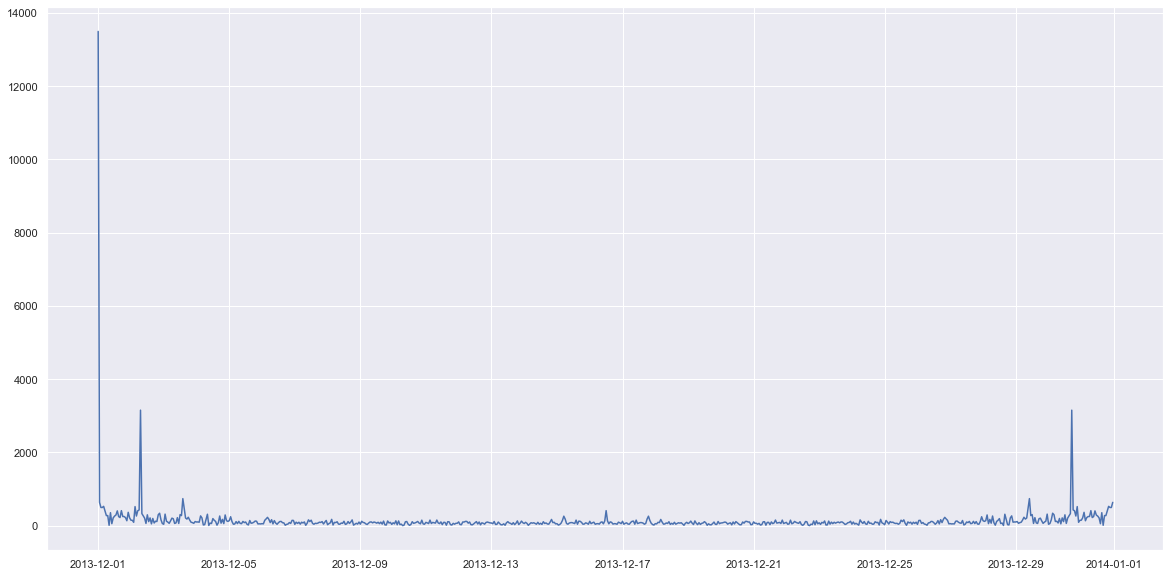

In [28]:
#Looking a Discrete Fourier Transform of one time series 
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

x = Complete.columns
y = Complete.loc[38].values
yf = scipy.fftpack.fft(y)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, np.abs(yf))
plt.show()

The Fourier Transform has reduced the dimensionality of the data to account for the oscilations observed within the data - removing the periodicity. I'll now look to perform this across data for all GRIDs. 

In [29]:
def generate_modulus_dataset(X):
    return np.abs(np.fft.fft(X))

DFT_abs = []

for grid in Complete.index:
    DFT_abs.append(generate_modulus_dataset(Complete.loc[grid]))

In [30]:
len(DFT_abs)

6259

## Performing PCA on the Fourier Transformed Data

In a standard experiment, the first step with PCA data is to normalise the data to ensure that each feature to be used in the PCA is normally distributed. I would normal perform this with the StandardScaler from SciKit Learn, however, this is the point at which I'm reaching the limit of my understanding of the Discrete Fourier Transform and Time Series data. I'm struggling to apply my knowledge of PCA to the output of a continuous time series outputted from the Discrete Fourier Transform. 

I have used PCA previously to look at individual datapoints to understand how a combination of features contributes to the variance of the dataset. I'm unsure on how to implement this when looking at a connected series of data. As such, I'm going to stop my investigations of the Discrete Fourier Transform and move onto clustering the data on the Euclidean distances between the time series. 

## Performing kMeans Clustering on Euclidean Distances between Time Series

Using the data prepped for the Discrete Fourier Transform, I will perform clustering on the time series data using Euclidean distances. 

I wondered whether it would be best to normalise the data prior to clustering, as this would highlight the pattern of data rather than the amplitudes - however, this would remove our ability to segregate regions on overall usage. As such, I'm initially going ahead with a clustering experiment on the raw data, with the option to normalise later.

I've used "k-means++" as the initialisation point as this initializes the starting centroids to be distant from each other, and has proven to have a greater clustering success compared to a random initialisation point. 

To determine the optimum number of clusters, a range of options will be trialled, looking to minimise the within cluster variance, or intertia (measured by the error sum of squares - SSE). 


In [31]:
EDkM = Complete

In [32]:
from tslearn.clustering import TimeSeriesKMeans



kmeans_args = {
    "metric": "euclidean",
    "max_iter": 300,
    "random_state": 42,
    "init": "k-means++"
}

sse = []

for k in range(1,40):
    kmeans = TimeSeriesKMeans(n_clusters = k, **kmeans_args)
    kmeans.fit(EDkM)
    sse.append(kmeans.inertia_)

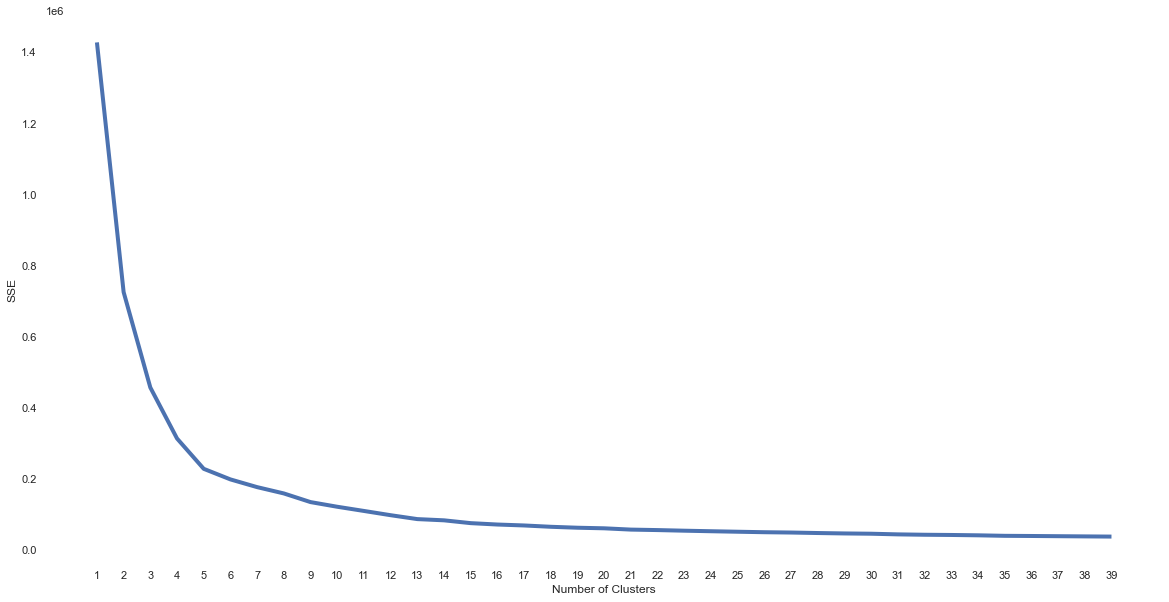

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))  
fig.patch.set_facecolor('#FFFFFF')

plt.style.use("fivethirtyeight")
plt.plot(range(1, 40), sse)
plt.xticks(range(1, 40))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
ax.set_facecolor('#FFFFFF')
plt.show()

The point at which the decrease in this graph stops being linear (i.e. the 'elbow' point) looks to be around 5. I will now perform a kMeans clustering experiment with 5 clusters.

In [34]:
model = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=300,random_state=0)
model.fit(EDkM)

TimeSeriesKMeans(max_iter=300, n_clusters=5, random_state=0)

In [35]:
pd.set_option("display.max_rows", 20, "display.max_columns", 50) 

clusters = pd.Series(model.labels_)
EDkM['assigned_cluster'] = clusters.values
EDkM

DateTime  2013-12-01 00:00:00  2013-12-01 01:00:00  2013-12-01 02:00:00  \
GRID                                                                      
38                  13.931525            10.326146             8.148137   
39                  10.174798             8.818236             7.264167   
40                  13.914802            11.260299             9.943673   
154                 12.279217            11.980474             8.482760   
155                 15.999255            13.446890            11.125100   
...                       ...                  ...                  ...   
11336                1.780888             0.769706             0.758914   
11337                2.765469             2.271976             2.151053   
11452               22.781224            14.051233            13.953498   
11453                6.842236             6.662084             6.842741   
11454                3.554573             3.810874             3.809247   

DateTime  2013-12-01 03:00:00  2013-12-01 04:00:00  2013-12-01 05:00:00  \
GRID                                                                      
38                   7.032447             7.437181             6.717715   
39                   6.542810             6.061952             6.157371   
40                   9.569573             8.715929             8.738979   
154                  8.089366             7.514651             7.418298   
155                 10.111391             9.110057             9.206154   
...                       ...                  ...                  ...   
11336                0.493920             0.478351             0.454702   
11337                1.836487             2.539130             2.021801   
11452               12.358247            11.104122            10.253647   
11453                6.333882             6.290232             5.454611   
11454                3.001196             4.596320             3.561439   

DateTime  2013-12-01 06:00:00  2013-12-01 07:00:00  2013-12-01 08:00:00  \
GRID                                                                      
38                   6.193324             9.330894            20.250008   
39                   5.501376             8.874039            30.740103   
40                   8.718242             9.479200            11.458270   
154                  6.757977            13.448438            46.613438   
155                  8.547113            13.004840            40.526360   
...                       ...                  ...                  ...   
11336                0.397385             0.472357             1.919870   
11337                1.961259             1.920863             4.172727   
11452                8.279007            10.766999            17.806807   
11453                4.683798             5.736372             8.136391   
11454                3.582514             3.414861             5.969997   

DateTime  2013-12-01 09:00:00  2013-12-01 10:00:00  2013-12-01 11:00:00  \
GRID                                                                      
38                  22.276437            28.993893            25.834675   
39                  32.046573            26.470919            22.883371   
40                  14.201950            14.870823            17.087132   
154                 56.202424            35.020453            34.176896   
155                 47.069170            36.895423            33.228534   
...                       ...                  ...                  ...   
11336                1.411006             2.385706             1.552874   
11337                6.878472             5.075162             7.662985   
11452               24.717432            31.456898            41.120620   
11453               11.196794            13.027627            15.052057   
11454                6.362822             5.798535            10.926713   

DateTime  2013-12-01 12:00:00  2013-12-01 13:00:00  2013-12-01 14:00:00  \
GRID                 

In [281]:
EDkM_indexed.groupby('assigned_cluster').GRID.nunique()

assigned_cluster
0    5224
1       3
2       8
3      97
4     927
Name: GRID, dtype: int64

The majority of GRIDs have fallen into the first cluster, it will be interesting to see how these clusters look, and whether further clustering is required on cluster 0. 

Addtionally, we see a couple of clusters with only a few records within them - it will be interesting to see whether there are trends within these clusters that look similar to other clusters, or whether they are in fact distinct clusters. 

I'll now start looking at the trends observed within each of these clusters to understand them a little more.

In [36]:
EDkM_indexed = EDkM.reset_index()

In [38]:
EDkM_unpivot = pd.melt(EDkM_indexed, id_vars=['GRID', 'assigned_cluster'], var_name='DateTime', value_name='InternetActivity')

EDkM_0 = EDkM_unpivot[(EDkM_unpivot['assigned_cluster'] == 0)]
EDkM_1 = EDkM_unpivot[(EDkM_unpivot['assigned_cluster'] == 1)]
EDkM_2 = EDkM_unpivot[(EDkM_unpivot['assigned_cluster'] == 2)]
EDkM_3 = EDkM_unpivot[(EDkM_unpivot['assigned_cluster'] == 3)]
EDkM_4 = EDkM_unpivot[(EDkM_unpivot['assigned_cluster'] == 4)]

In [196]:
def make_agg_df(input_dataframe: pd.DataFrame):
    EDkM_agg = pd.DataFrame()
    EDkM_agg['iqr_lower'] = input_dataframe.groupby('DateTime').InternetActivity.quantile(0.25) 
    EDkM_agg['iqr_upper'] = input_dataframe.groupby('DateTime').InternetActivity.quantile(0.75)
    EDkM_agg['median'] = input_dataframe.groupby('DateTime').InternetActivity.median()
    EDkM_agg['mean'] = input_dataframe.groupby('DateTime').InternetActivity.mean()
    EDkM_agg['min'] = input_dataframe.groupby('DateTime').InternetActivity.min()
    EDkM_agg['max'] = input_dataframe.groupby('DateTime').InternetActivity.max()
    
    return EDkM_agg

def make_graph(input_dataframe: pd.DataFrame, title: str, xlim_start: int=None, xlim_end: int=None, ylim_start: int=None, ylim_end: int=None, lwidth: int=2, incmin=False, incmax=False):
    agg_df = make_agg_df(input_dataframe)
    ax = sns.lineplot(agg_df.index.values, agg_df['mean'], color='green', label='Mean', linewidth=lwidth) 
    ax = sns.lineplot(agg_df.index.values, agg_df['median'], color = 'red', label='Median', linewidth=lwidth) 
    if incmin:
        ax = sns.lineplot(agg_df.index.values, agg_df['min'], color = 'black', label='Min', linewidth=lwidth) 
    if incmax:
        ax = sns.lineplot(agg_df.index.values, agg_df['max'], color = 'black', label='Max', linewidth=lwidth) 
    ax.fill_between(agg_df.index.values, agg_df['iqr_lower'], agg_df['iqr_upper'], alpha=0.3, label='Interquartile Range', linewidth=lwidth)
    plt.ylabel('Internet Usage')
    plt.title(title)
    plt.xlim(xlim_start, xlim_end)
    plt.ylim(ylim_start, ylim_end)
    ax.set_facecolor('#FFFFFF')

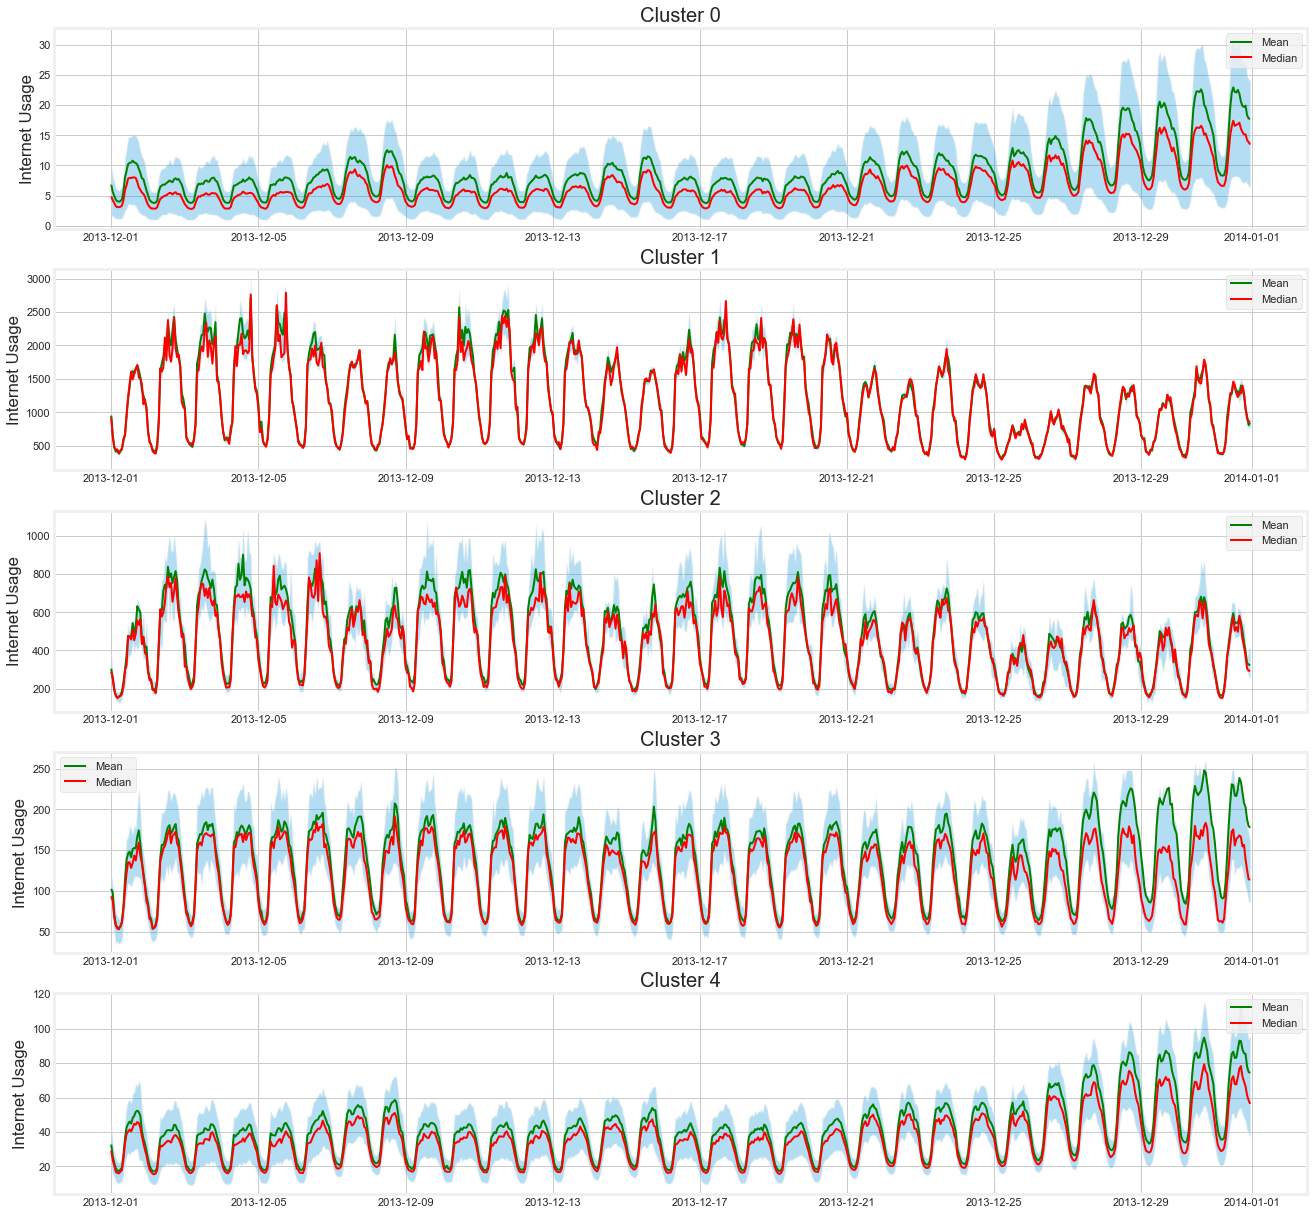

In [200]:
fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(5, 1, 1)
make_graph(EDkM_0, "Cluster 0")
plt.subplot(5, 1, 2)
make_graph(EDkM_1, "Cluster 1")
plt.subplot(5, 1, 3)
make_graph(EDkM_2, "Cluster 2")
plt.subplot(5, 1, 4)
make_graph(EDkM_3, "Cluster 3")
plt.subplot(5, 1, 5)
make_graph(EDkM_4, "Cluster 4")

plt.show()


Firstly, I'm really happy with the output of this clustering. It seems to have split out some nicely distinct patterns as well as clustering on overal magnitude of activity. The number of GRIDs in each cluster is relatively uneven, and explains the broader interquartile ranges observed across clusters 0, 3 and 4 respectively.  

I'm going to plot these together with the same y-axis limits, and perform some specific interrogations on each cluster, before commenting on the trends across the clusters I have identified.

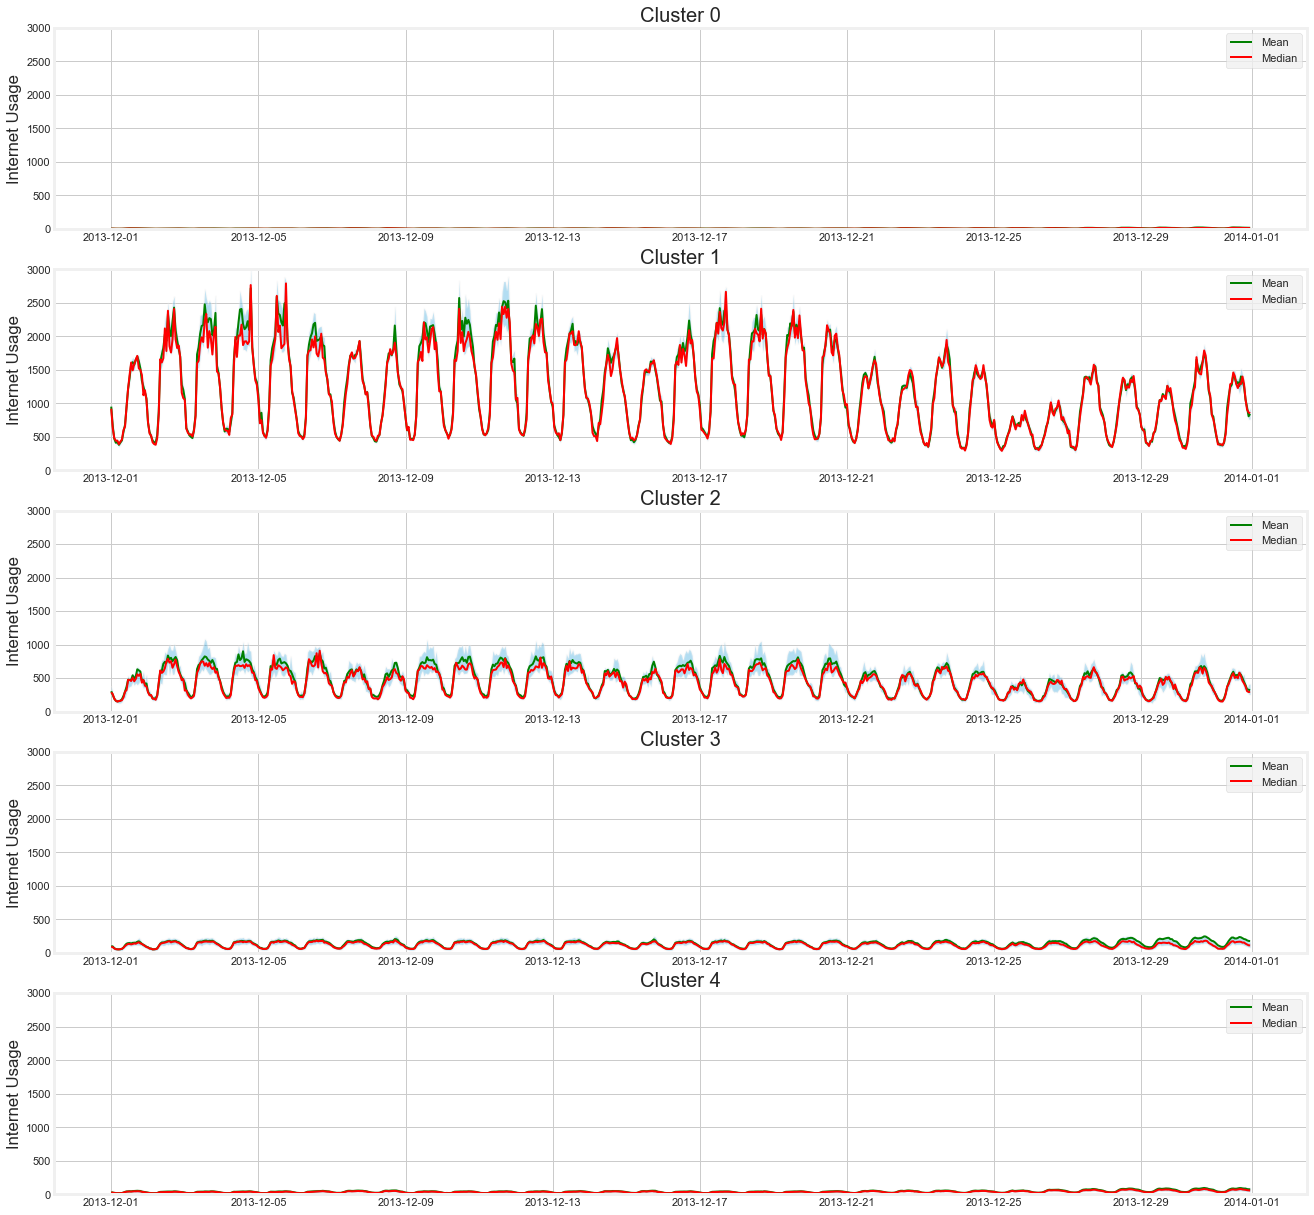

In [201]:
fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(5, 1, 1)
make_graph(EDkM_0, "Cluster 0", ylim_start=0, ylim_end=3000)
plt.subplot(5, 1, 2)
make_graph(EDkM_1, "Cluster 1", ylim_start=0, ylim_end=3000)
plt.subplot(5, 1, 3)
make_graph(EDkM_2, "Cluster 2", ylim_start=0, ylim_end=3000)
plt.subplot(5, 1, 4)
make_graph(EDkM_3, "Cluster 3", ylim_start=0, ylim_end=3000)
plt.subplot(5, 1, 5)
make_graph(EDkM_4, "Cluster 4", ylim_start=0, ylim_end=3000)
plt.show()

## Analysing Cluster 0


Cluster 0 has the highest number of GRIDs within it, with around 83% of the data falling into this category. 

There looked to be an interesting weekly trend in the graphs above - with an increase in activity observed over the weekend in this region. These will be looked into in more detail below. 

In [285]:

Weekends = pd.DataFrame({'Date':['2013-12-01', '2013-12-07', '2013-12-08', '2013-12-14', '2013-12-15', '2013-12-21', '2013-12-22']})
Weekends['WeekendFlag'] = 1
Weekends['Date'] = pd.to_datetime(Weekends['Date'])

def create_weekend_flag(input_dataframe: pd.DataFrame):
    weekendflag = input_dataframe
    weekendflag['Date'] = pd.to_datetime(input_dataframe['DateTime'].dt.date)
    weekendflag['Time'] = weekendflag['DateTime'].dt.hour
    weekendflag = input_dataframe.merge(Weekends, how='left', left_on='Date', right_on='Date')
    weekendflag['WeekendFlag'] = weekendflag['WeekendFlag'].replace(np.nan, 0)
    weekendflag['WeekendFlag'] = pd.to_numeric(weekendflag['WeekendFlag'])
    return weekendflag

def make_week_time_agg(input_dataframe: pd.DataFrame, weekendflag: int=0, beforechristmas=True, afterchristmas=False):
    flagged = create_weekend_flag(input_dataframe)
    flagged = flagged[(flagged['WeekendFlag'] == weekendflag)]
    if beforechristmas:
        flagged = flagged[(flagged['Date'] < '2013-12-22')]
    if afterchristmas:
        flagged = flagged[(flagged['Date'] >= '2013-12-22')]
    time_agg = pd.DataFrame()
    time_agg['iqr_lower'] = flagged.groupby('Time').InternetActivity.quantile(0.25) 
    time_agg['iqr_upper'] = flagged.groupby('Time').InternetActivity.quantile(0.75)
    time_agg['median'] = flagged.groupby('Time').InternetActivity.median()
    time_agg['mean'] = flagged.groupby('Time').InternetActivity.mean()
    time_agg['min'] = flagged.groupby('Time').InternetActivity.min()
    time_agg['max'] = flagged.groupby('Time').InternetActivity.max()
    return time_agg


def create_time_graph(input_dataframe: pd.DataFrame, title: str, weekendflag: int=0, beforechristmas=True, afterchristmas=False, lwidth: int=2, ylim_start: int=None, ylim_end: int=None, incmin=False, incmax=False):
    time_agg = make_week_time_agg(input_dataframe, weekendflag = weekendflag)
    ax = sns.lineplot(time_agg.index.values, time_agg['mean'], color='green', label='Mean', linewidth=lwidth) 
    ax = sns.lineplot(time_agg.index.values, time_agg['median'], color = 'red', label='Median', linewidth=lwidth) 
    if incmin:
        ax = sns.lineplot(time_agg.index.values, time_agg['min'], color = 'black', label='Min', linewidth=lwidth) 
    if incmax:
        ax = sns.lineplot(time_agg.index.values, time_agg['max'], color = 'black', label='Max', linewidth=lwidth) 
    ax.fill_between(time_agg.index.values, time_agg['iqr_lower'], time_agg['iqr_upper'], alpha=0.3, label='Interquartile Range', linewidth=lwidth)
    plt.ylabel('Internet Usage')
    plt.title(title)
    plt.ylim(ylim_start, ylim_end)
    ax.set_facecolor('#FFFFFF')

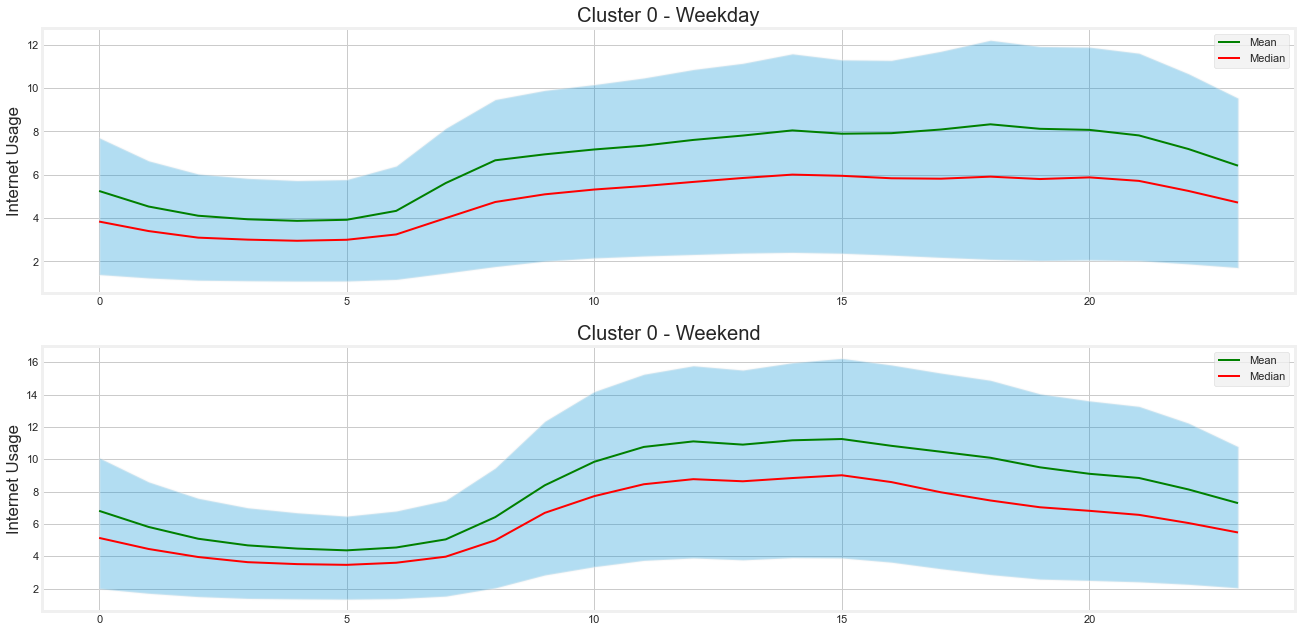

In [290]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(2, 1, 1)
create_time_graph(EDkM_0, weekendflag=0, title="Cluster 0 - Weekday")
plt.subplot(2, 1, 2)
create_time_graph(EDkM_0, weekendflag=1, title="Cluster 0 - Weekend")

plt.show()

There definitely looks to be a magnitude difference at the weekend (peak mean ~11) compared to the weekdays (peak mean ~8). But with a high level of skew still present in this data, it's difficult to come to any conclusive answers.

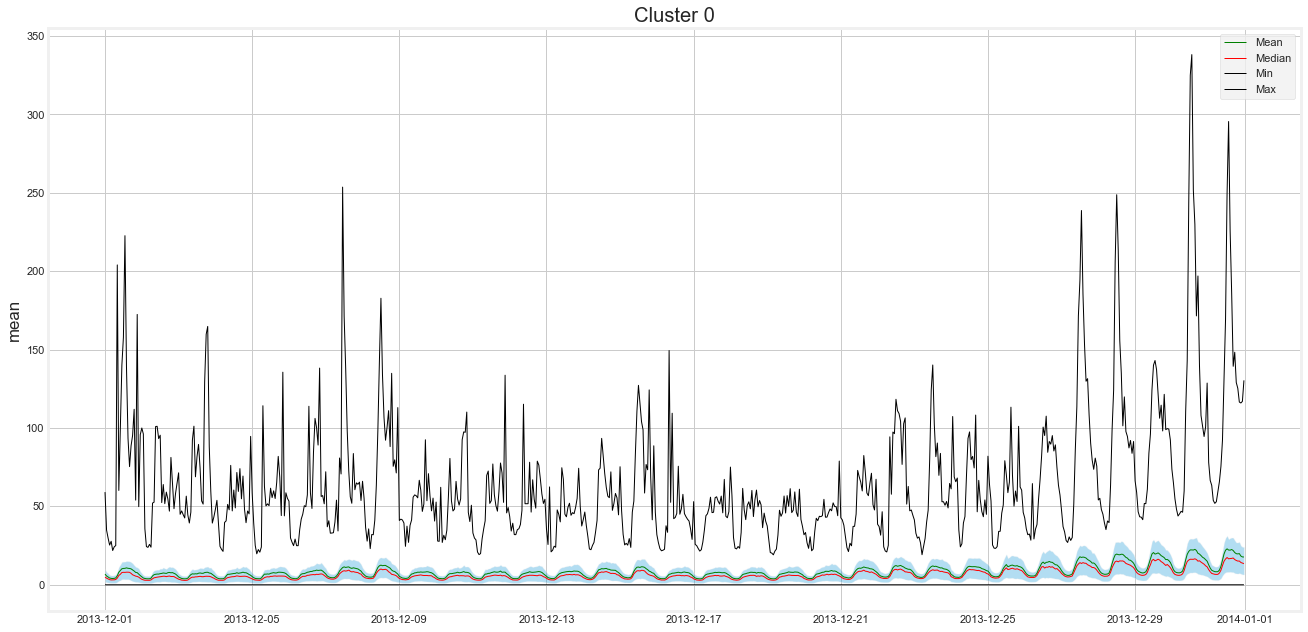

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('#FFFFFF')
make_graph(EDkM_0, "Cluster 0", lwidth=1, incmin=True, incmax=True)
plt.show()

In light of the broad range of data in this cluster and the fact it contains more than 80% of the original data, I'm going to perform a further clustering experiment on this cluster to see if we can see a greater resolution data within this category.  

In [291]:
Cluster0 = EDkM[(EDkM['assigned_cluster']==0)]
Cluster0 = Cluster0.drop(['assigned_cluster'], axis=1)

kmeans_args = {
    "metric": "euclidean",
    "max_iter": 300,
    "random_state": 42,
    "init": "k-means++"
}

sse = []

for k in range(1,40):
    kmeans = TimeSeriesKMeans(n_clusters = k, **kmeans_args)
    kmeans.fit(Cluster0)
    sse.append(kmeans.inertia_)

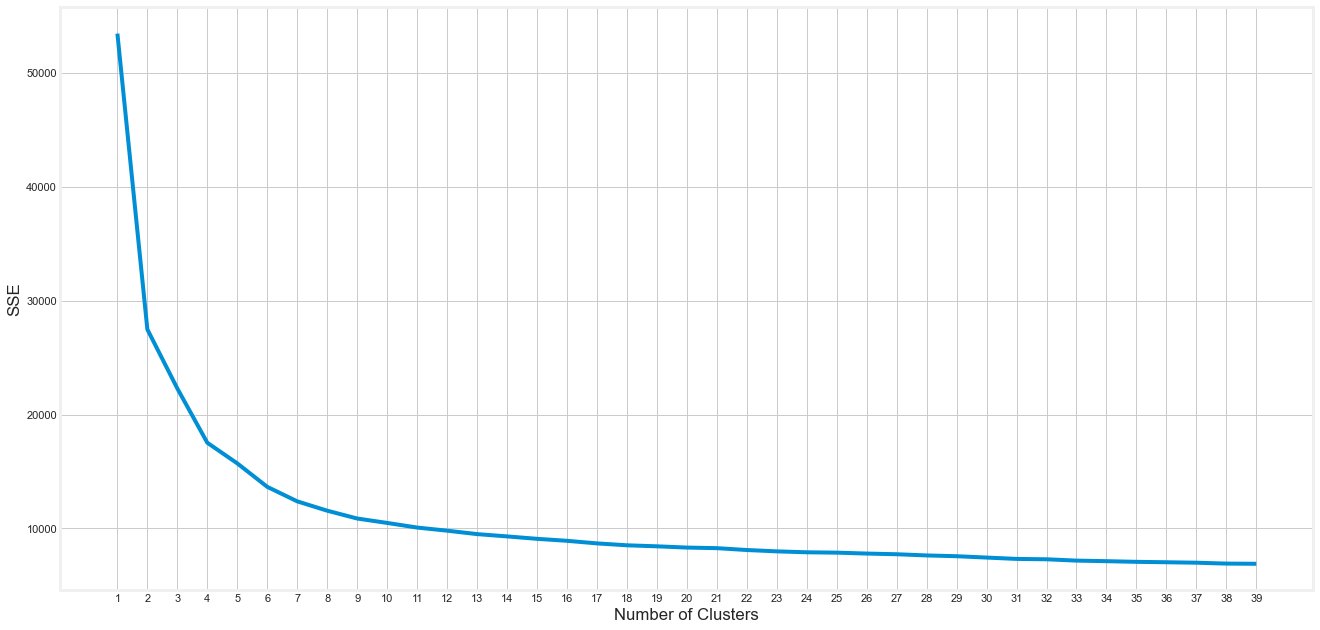

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))  
fig.patch.set_facecolor('#FFFFFF')

plt.style.use("fivethirtyeight")
plt.plot(range(1, 40), sse)
plt.xticks(range(1, 40))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
ax.set_facecolor('#FFFFFF')
plt.show()

I think the elbow point of this curve looks to be about 6, so I will take that forward for the kMeans clustering experiment. 

In [45]:
model = TimeSeriesKMeans(n_clusters=6, metric="euclidean", max_iter=300,random_state=0)
model.fit(Cluster0)

pd.set_option("display.max_rows", 20, "display.max_columns", 50) 

NewClusters = pd.Series(model.labels_)
Cluster0['assigned_cluster'] = NewClusters.values
Cluster0

DateTime  2013-12-01 00:00:00  2013-12-01 01:00:00  2013-12-01 02:00:00  \
GRID                                                                      
38                  13.931525            10.326146             8.148137   
39                  10.174798             8.818236             7.264167   
40                  13.914802            11.260299             9.943673   
156                 13.924045            11.207872            10.147760   
158                  7.590959             6.729703             4.935303   
...                       ...                  ...                  ...   
11218                4.584354             1.893045             1.524210   
11219                3.133539             1.563060             1.549207   
11220                1.578901             1.610673             1.691180   
11336                1.780888             0.769706             0.758914   
11337                2.765469             2.271976             2.151053   

DateTime  2013-12-01 03:00:00  2013-12-01 04:00:00  2013-12-01 05:00:00  \
GRID                                                                      
38                   7.032447             7.437181             6.717715   
39                   6.542810             6.061952             6.157371   
40                   9.569573             8.715929             8.738979   
156                  9.698009             8.288277             8.995426   
158                  3.986744             3.244122             3.303568   
...                       ...                  ...                  ...   
11218                0.779238             1.073070             0.923089   
11219                1.198543             1.082897             0.992769   
11220                2.134703             1.853487             1.470365   
11336                0.493920             0.478351             0.454702   
11337                1.836487             2.539130             2.021801   

DateTime  2013-12-01 06:00:00  2013-12-01 07:00:00  2013-12-01 08:00:00  \
GRID                                                                      
38                   6.193324             9.330894            20.250008   
39                   5.501376             8.874039            30.740103   
40                   8.718242             9.479200            11.458270   
156                  8.265711             9.352783            30.141897   
158                  3.800567             3.899884             6.475539   
...                       ...                  ...                  ...   
11218                0.984486             1.310228             3.190408   
11219                0.976588             0.961800             3.569243   
11220                1.486091             1.324807             2.372057   
11336                0.397385             0.472357             1.919870   
11337                1.961259             1.920863             4.172727   

DateTime  2013-12-01 09:00:00  2013-12-01 10:00:00  2013-12-01 11:00:00  \
GRID                                                                      
38                  22.276437            28.993893            25.834675   
39                  32.046573            26.470919            22.883371   
40                  14.201950            14.870823            17.087132   
156                 24.863803            29.036697            22.234536   
158                  6.762147             7.289068             8.676723   
...                       ...                  ...                  ...   
11218                4.051429             6.641313             4.273192   
11219                4.282768             4.205106             3.275216   
11220                8.582655             3.865960             4.871435   
11336                1.411006             2.385706             1.552874   
11337                6.878472             5.075162             7.662985   

DateTime  2013-12-01 12:00:00  2013-12-01 13:00:00  2013-12-01 14:00:00  \
GRID                 

In [46]:
Cluster0_indexed = Cluster0.reset_index()
Cluster0_unpivot = Cluster0_indexed = pd.melt(Cluster0_indexed, id_vars=['GRID', 'assigned_cluster'], var_name='DateTime', value_name='InternetActivity')

# Cluster0_unpivot.groupby('assigned_cluster').GRID.nunique()

In [47]:

Cluster00 = Cluster0_unpivot[(Cluster0_unpivot['assigned_cluster'] == 0)]
Cluster01 = Cluster0_unpivot[(Cluster0_unpivot['assigned_cluster'] == 1)]
Cluster02 = Cluster0_unpivot[(Cluster0_unpivot['assigned_cluster'] == 2)]
Cluster03 = Cluster0_unpivot[(Cluster0_unpivot['assigned_cluster'] == 3)]
Cluster04 = Cluster0_unpivot[(Cluster0_unpivot['assigned_cluster'] == 4)]
Cluster05 = Cluster0_unpivot[(Cluster0_unpivot['assigned_cluster'] == 5)]


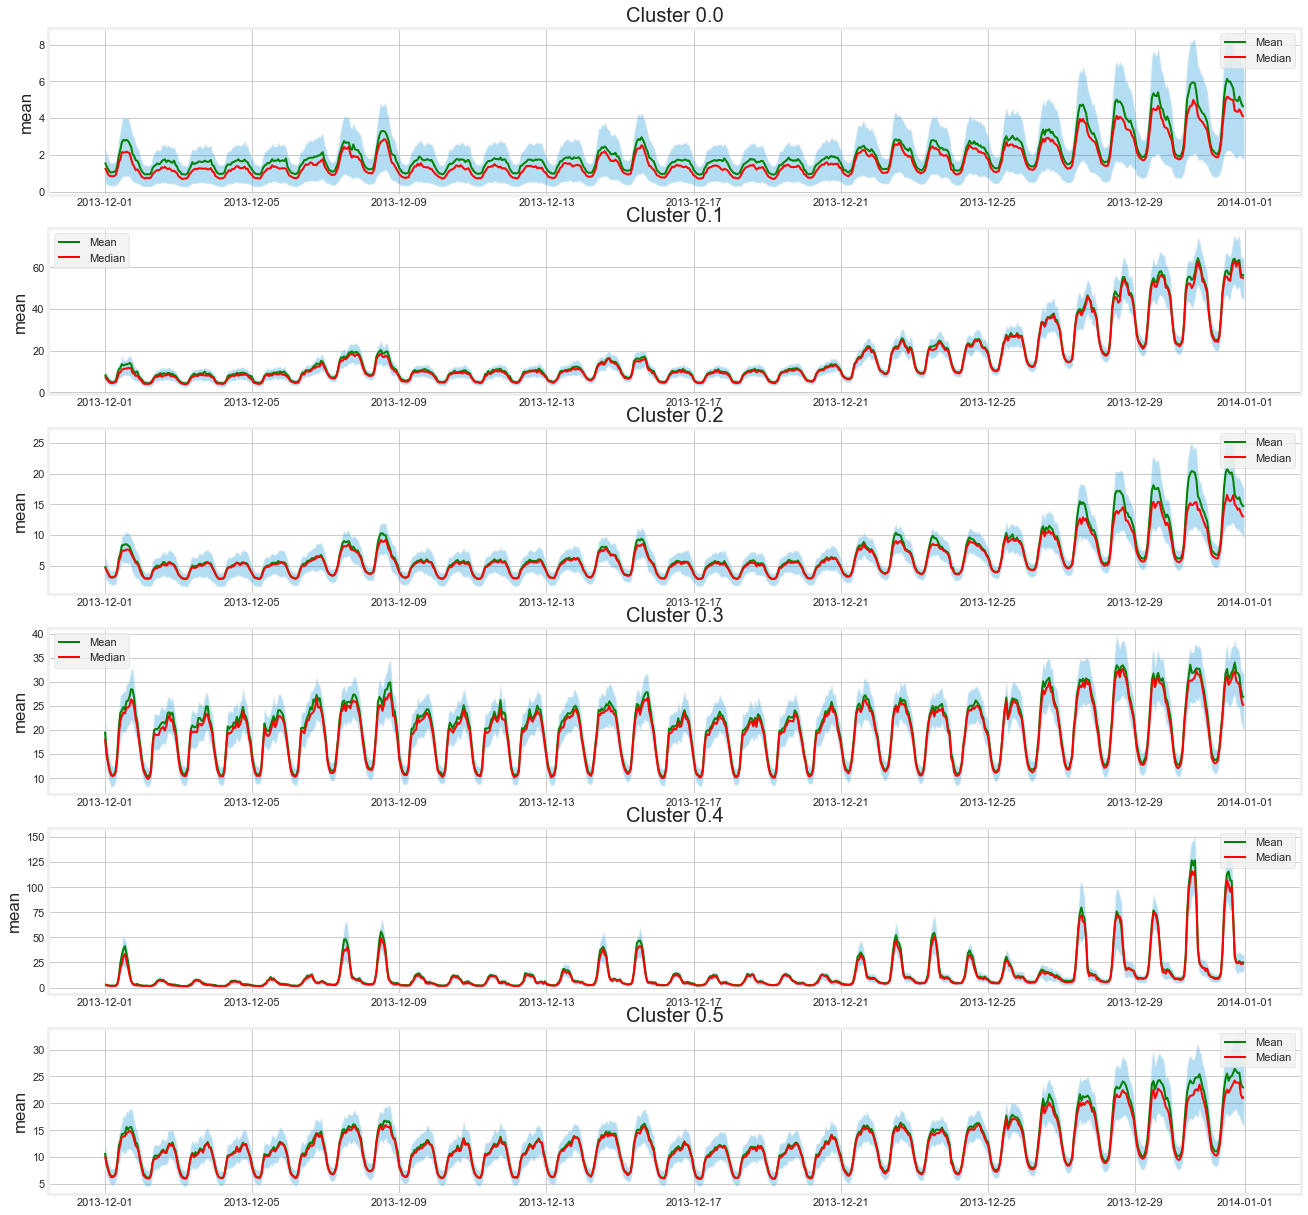

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(6, 1, 1)
make_graph(Cluster00, "Cluster 0.0")
plt.subplot(6, 1, 2)
make_graph(Cluster01, "Cluster 0.1")
plt.subplot(6, 1, 3)
make_graph(Cluster02, "Cluster 0.2")
plt.subplot(6, 1, 4)
make_graph(Cluster03, "Cluster 0.3")
plt.subplot(6, 1, 5)
make_graph(Cluster04, "Cluster 0.4")
plt.subplot(6, 1, 6)
make_graph(Cluster05, "Cluster 0.5")


plt.show()

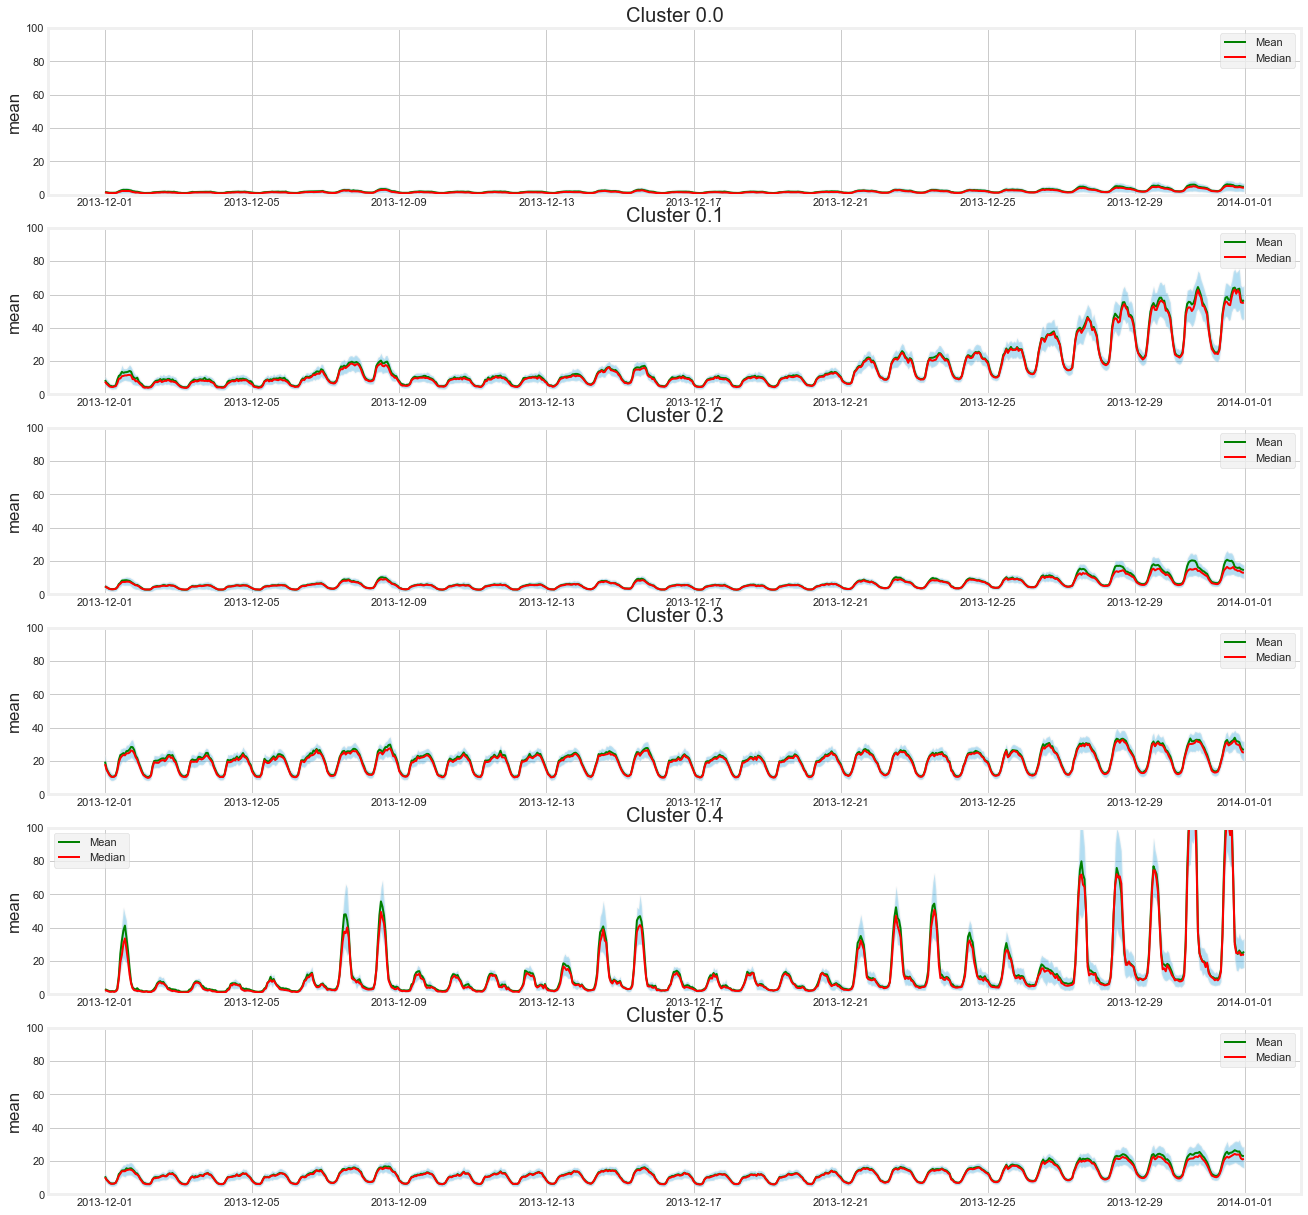

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(6, 1, 1)
make_graph(Cluster00, "Cluster 0.0", ylim_start=0, ylim_end=100)
plt.subplot(6, 1, 2)
make_graph(Cluster01, "Cluster 0.1", ylim_start=0, ylim_end=100)
plt.subplot(6, 1, 3)
make_graph(Cluster02, "Cluster 0.2", ylim_start=0, ylim_end=100)
plt.subplot(6, 1, 4)
make_graph(Cluster03, "Cluster 0.3", ylim_start=0, ylim_end=100)
plt.subplot(6, 1, 5)
make_graph(Cluster04, "Cluster 0.4", ylim_start=0, ylim_end=100)
plt.subplot(6, 1, 6)
make_graph(Cluster05, "Cluster 0.5", ylim_start=0, ylim_end=100)


plt.show()

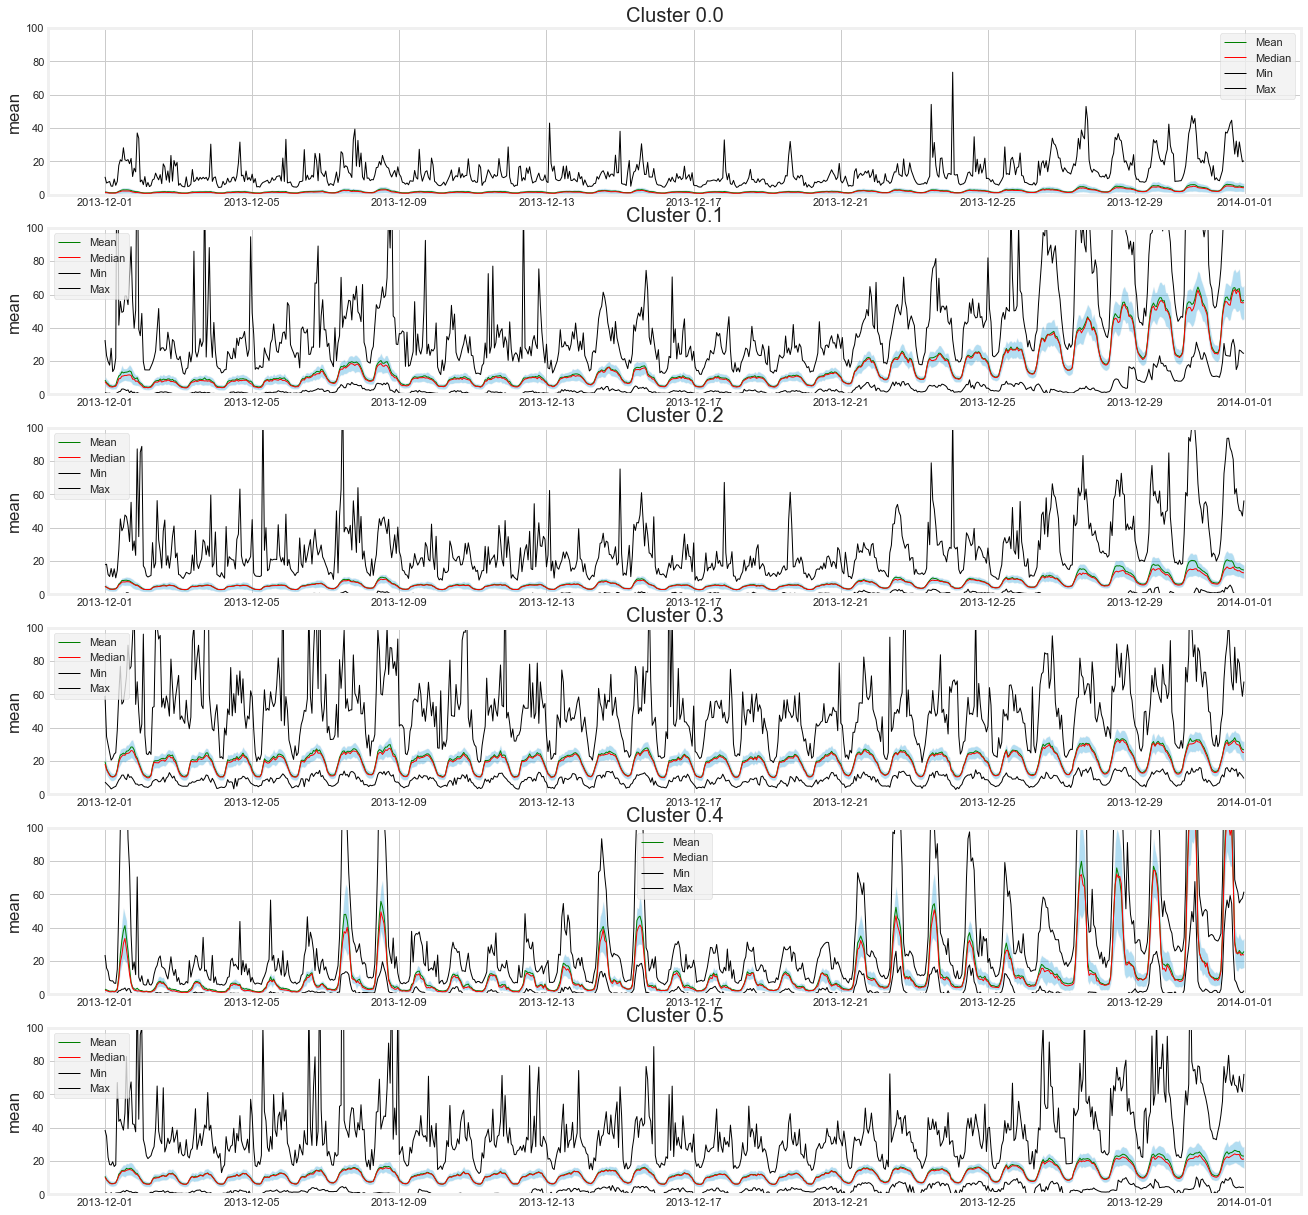

In [50]:
fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(6, 1, 1)
make_graph(Cluster00, "Cluster 0.0", ylim_start=0, ylim_end=100, lwidth=1, incmin=True, incmax=True)
plt.subplot(6, 1, 2)
make_graph(Cluster01, "Cluster 0.1", ylim_start=0, ylim_end=100, lwidth=1, incmin=True, incmax=True)
plt.subplot(6, 1, 3)
make_graph(Cluster02, "Cluster 0.2", ylim_start=0, ylim_end=100, lwidth=1, incmin=True, incmax=True)
plt.subplot(6, 1, 4)
make_graph(Cluster03, "Cluster 0.3", ylim_start=0, ylim_end=100, lwidth=1, incmin=True, incmax=True)
plt.subplot(6, 1, 5)
make_graph(Cluster04, "Cluster 0.4", ylim_start=0, ylim_end=100, lwidth=1, incmin=True, incmax=True)
plt.subplot(6, 1, 6)
make_graph(Cluster05, "Cluster 0.5", ylim_start=0, ylim_end=100, lwidth=1, incmin=True, incmax=True)


plt.show()

It looks like we have managed to find further distinct clusters within this group. I'm again seeing patterns based on both magnitude and pattern of activity. 

Clusters 0.0, 0.1 and 0.2 all look to have a similar pattern with increases in activity over the weekends and holiday periods. However, these appear to be differentiated by their magnitude of activity. 

Clusters 0.3 and 0.5 again seem to have similar patterns, with a steady level of internet activity over the week and minimal or no increase in activity over the holiday period. 

Cluster 0.4 is really interesting - it looks to have a much tighter peak of activity during the day and has a dramatic increase in activity on the weekends compared to the week, with a large increase over the Christmas period. Notably the bank holidays over the Christmas period have markedly lower activity. Could this related to retail parks?  

I'd like to take a look at the daily patterns and the differences observed in these when looking at week days, weekends and the holiday period. 

In [233]:
Weekends = pd.DataFrame({'Date':['2013-12-01', '2013-12-07', '2013-12-08', '2013-12-14', '2013-12-15', '2013-12-21', '2013-12-22']})
Weekends['WeekendFlag'] = 1
Weekends['Date'] = pd.to_datetime(Weekends['Date'])

def create_weekend_flag(input_dataframe: pd.DataFrame):
    weekendflag = input_dataframe
    weekendflag['Date'] = pd.to_datetime(input_dataframe['DateTime'].dt.date)
    weekendflag['Time'] = weekendflag['DateTime'].dt.hour
    weekendflag = input_dataframe.merge(Weekends, how='left', left_on='Date', right_on='Date')
    weekendflag['WeekendFlag'] = weekendflag['WeekendFlag'].replace(np.nan, 0)
    weekendflag['WeekendFlag'] = pd.to_numeric(weekendflag['WeekendFlag'])
    return weekendflag

def make_week_time_agg(input_dataframe: pd.DataFrame, weekendflag: int=0, beforechristmas=True, afterchristmas=False):
    flagged = create_weekend_flag(input_dataframe)
    flagged = flagged[(flagged['WeekendFlag'] == weekendflag)]
    if beforechristmas:
        flagged = flagged[(flagged['Date'] < '2013-12-22')]
    if afterchristmas:
        flagged = flagged[(flagged['Date'] >= '2013-12-22')]
    time_agg = pd.DataFrame()
    time_agg['iqr_lower'] = flagged.groupby('Time').InternetActivity.quantile(0.25) 
    time_agg['iqr_upper'] = flagged.groupby('Time').InternetActivity.quantile(0.75)
    time_agg['median'] = flagged.groupby('Time').InternetActivity.median()
    time_agg['mean'] = flagged.groupby('Time').InternetActivity.mean()
    time_agg['min'] = flagged.groupby('Time').InternetActivity.min()
    time_agg['max'] = flagged.groupby('Time').InternetActivity.max()
    return time_agg


def create_time_graph(input_dataframe: pd.DataFrame, title: str, beforechristmas=True, afterchristmas=False, weekendflag: int=0, lwidth: int=2, ylim_start: int=None, ylim_end: int=None, incmin=False, incmax=False):
    time_agg = make_week_time_agg(input_dataframe, weekendflag = weekendflag, beforechristmas=True, afterchristmas=False)
    ax = sns.lineplot(time_agg.index.values, time_agg['mean'], color='green', label='Mean', linewidth=lwidth) 
    ax = sns.lineplot(time_agg.index.values, time_agg['median'], color = 'red', label='Median', linewidth=lwidth) 
    if incmin:
        ax = sns.lineplot(time_agg.index.values, time_agg['min'], color = 'black', label='Min', linewidth=lwidth) 
    if incmax:
        ax = sns.lineplot(time_agg.index.values, time_agg['max'], color = 'black', label='Max', linewidth=lwidth) 
    ax.fill_between(time_agg.index.values, time_agg['iqr_lower'], time_agg['iqr_upper'], alpha=0.3, label='Interquartile Range', linewidth=lwidth)
    plt.ylabel('Internet Usage')
    plt.title(title)
    plt.ylim(ylim_start, ylim_end)
    ax.set_facecolor('#FFFFFF')

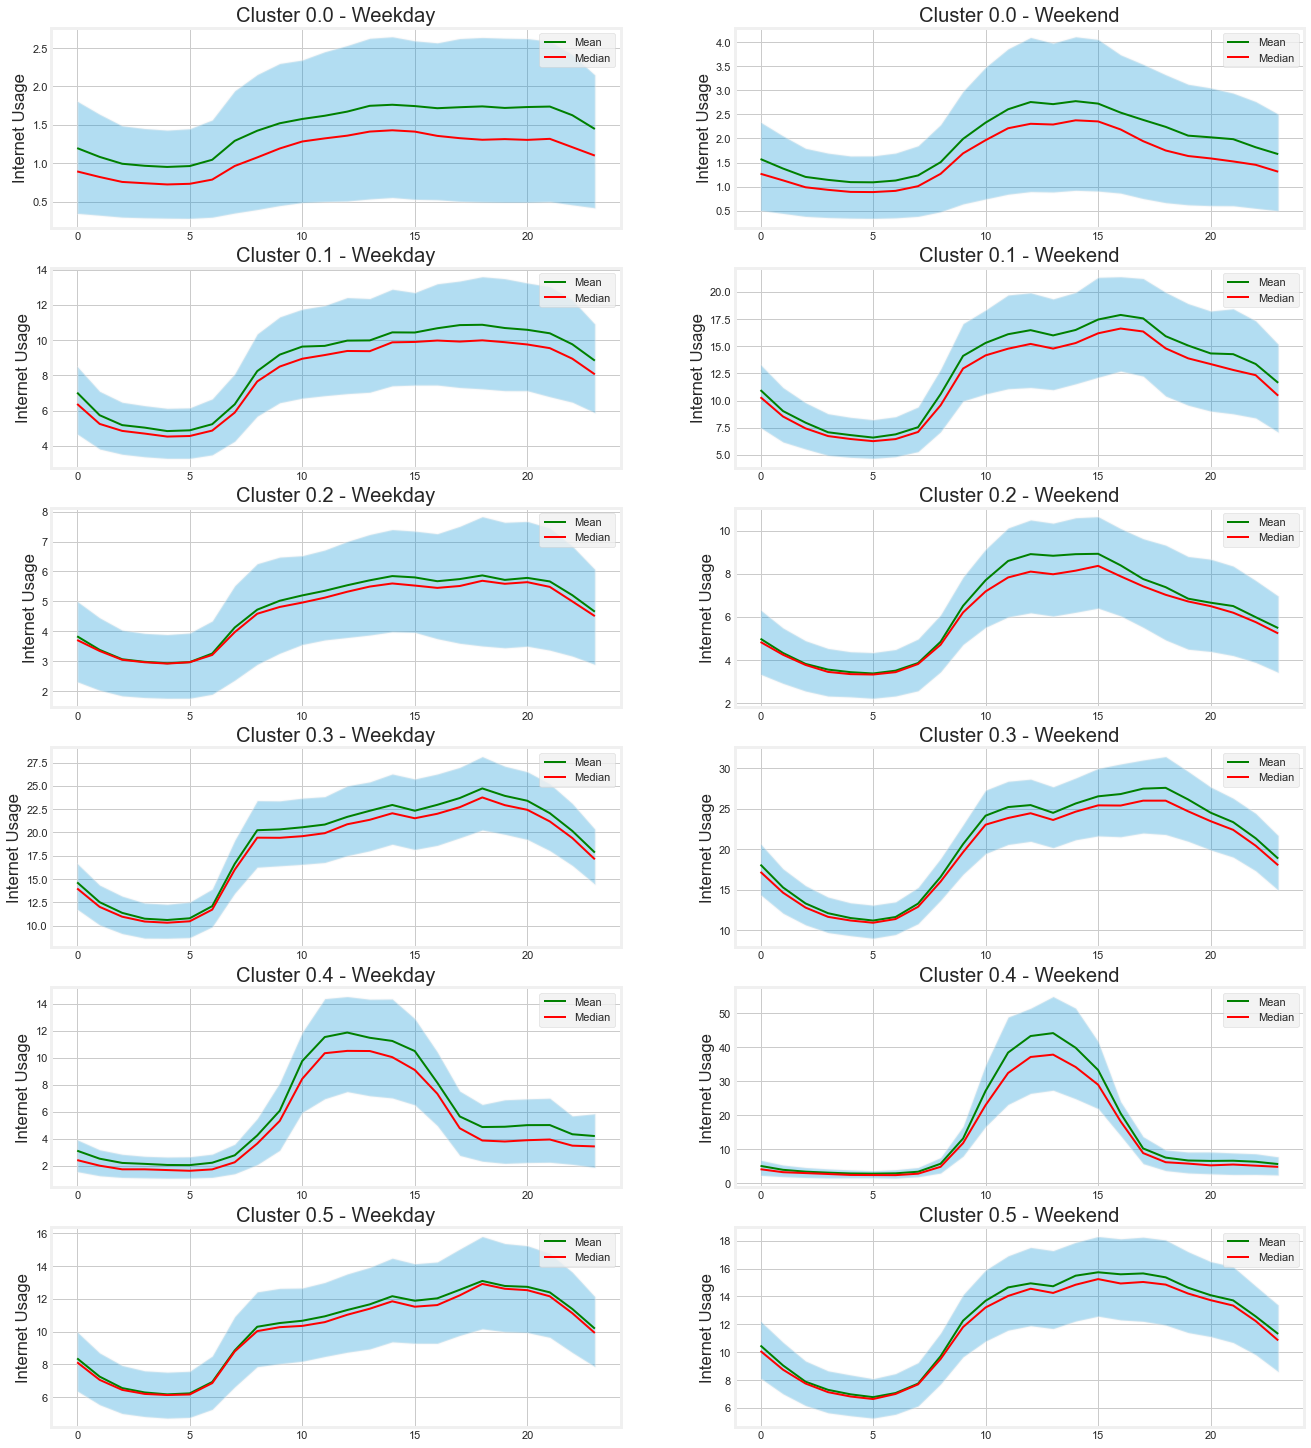

In [234]:
fig, ax = plt.subplots(figsize=(20, 24))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(6, 2, 1)
create_time_graph(Cluster00, weekendflag=0, title="Cluster 0.0 - Weekday")
plt.subplot(6, 2, 2)
create_time_graph(Cluster00, weekendflag=1, title="Cluster 0.0 - Weekend")
plt.subplot(6, 2, 3)
create_time_graph(Cluster01, weekendflag=0, title="Cluster 0.1 - Weekday")
plt.subplot(6, 2, 4)
create_time_graph(Cluster01, weekendflag=1, title="Cluster 0.1 - Weekend")
plt.subplot(6, 2, 5)
create_time_graph(Cluster02, weekendflag=0, title="Cluster 0.2 - Weekday")
plt.subplot(6, 2, 6)
create_time_graph(Cluster02, weekendflag=1, title="Cluster 0.2 - Weekend")
plt.subplot(6, 2, 7)
create_time_graph(Cluster03, weekendflag=0, title="Cluster 0.3 - Weekday")
plt.subplot(6, 2, 8)
create_time_graph(Cluster03, weekendflag=1, title="Cluster 0.3 - Weekend")
plt.subplot(6, 2, 9)
create_time_graph(Cluster04, weekendflag=0, title="Cluster 0.4 - Weekday")
plt.subplot(6, 2, 10)
create_time_graph(Cluster04, weekendflag=1, title="Cluster 0.4 - Weekend")
plt.subplot(6, 2, 11)
create_time_graph(Cluster05, weekendflag=0, title="Cluster 0.5 - Weekday")
plt.subplot(6, 2, 12)
create_time_graph(Cluster05, weekendflag=1, title="Cluster 0.5 - Weekend")

plt.show()

It's interesting to see that for all of these clusters the daily peak is narrower on the weekends than it is on the weekdays. This adds weight to the idea that these are residential areas, as it correlates to later weekend waking hours. 

Cluster 0.4 still has my attention - the peak tends to follow business opening hours (8am - 5pm), but has sharp increases on the weekend and over Christmas. Which is totally at odds with what I would expect from a business. I thought maybe retail, but I wouldn't expect such dramatic differences on the weekends compared to the weekdays. 



I'd like to quantify the changes seen between the weekday and weekend patterns. As such, I'll look to compare the means at the peak of activity - to do this I'll look at the differences between the max of the means over the daily period. It would be good to spend some time analysing whether the peak occurs at different times in a more quantifiable way, but as this is a time boxed exercise, I'd like to move on. 

In [292]:
agg00 = make_week_time_agg(Cluster00)
agg01 = make_week_time_agg(Cluster01)
agg02 = make_week_time_agg(Cluster02)
agg03 = make_week_time_agg(Cluster03)
agg04 = make_week_time_agg(Cluster04)
agg05 = make_week_time_agg(Cluster05)

agg00_we = make_week_time_agg(Cluster00, 1)
agg01_we = make_week_time_agg(Cluster01, 1)
agg02_we = make_week_time_agg(Cluster02, 1)
agg03_we = make_week_time_agg(Cluster03, 1)
agg04_we = make_week_time_agg(Cluster04, 1)
agg05_we = make_week_time_agg(Cluster05, 1)

MaxAverages = pd.DataFrame()
MaxAverages['Cluster'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
MaxAverages['Weekday'] = [agg00['mean'].max(), agg01['mean'].max(), agg02['mean'].max(), agg03['mean'].max(), agg04['mean'].max(), agg05['mean'].max()]
MaxAverages['Weekend'] = [agg00_we['mean'].max(), agg01_we['mean'].max(), agg02_we['mean'].max(), agg03_we['mean'].max(), agg04_we['mean'].max(), agg05_we['mean'].max()]
MaxAverages['%Change'] = (MaxAverages['Weekend'] - MaxAverages['Weekday']) / MaxAverages['Weekday'] * 100
print(MaxAverages)

   Cluster    Weekday    Weekend     %Change
0      0.0   1.761948   2.773149   57.391076
1      0.1  10.870561  17.869072   64.380403
2      0.2   5.867886   8.929803   52.180925
3      0.3  24.726717  27.551319   11.423279
4      0.4  11.850323  44.105428  272.187576
5      0.5  13.089849  15.731289   20.179299


In [237]:
agg00_xm = make_week_time_agg(Cluster00, beforechristmas=False, afterchristmas=True)
agg01_xm = make_week_time_agg(Cluster01, beforechristmas=False, afterchristmas=True)
agg02_xm = make_week_time_agg(Cluster02, beforechristmas=False, afterchristmas=True)
agg03_xm = make_week_time_agg(Cluster03, beforechristmas=False, afterchristmas=True)
agg04_xm = make_week_time_agg(Cluster04, beforechristmas=False, afterchristmas=True)
agg05_xm = make_week_time_agg(Cluster05, beforechristmas=False, afterchristmas=True)

MaxAverages['Christmas'] = [agg00_xm['mean'].max(), agg01_xm['mean'].max(), agg02_xm['mean'].max(), agg03_xm['mean'].max(), agg04_xm['mean'].max(), agg05_xm['mean'].max()]
MaxAverages['%ChristmasChange'] = (MaxAverages['Christmas'] - MaxAverages['Weekday']) / MaxAverages['Weekday'] * 100
MaxAverages

Cluster    Weekday    Weekend     %Change  Christmas  %ChristmasChange
0      0.0   1.761948   2.773149   57.391076   4.336756        146.134167
1      0.1  10.870561  17.869072   64.380403  44.717956        311.367506
2      0.2   5.867886   8.929803   52.180925  14.795382        152.141614
3      0.3  24.726717  27.551319   11.423279  29.851968         20.727587
4      0.4  11.850323  44.105428  272.187576  66.571332        461.768102
5      0.5  13.089849  15.731289   20.179299  21.225159         62.149763

## Analysing Clusters 1 and 2

As clusters 1 and 2 have a very similar pattern (graphs replicated below), I have decided to normalise the InternetActivity for each GRID in these clusters, and plot these together to determine if their patterns are as similar as they appear. 

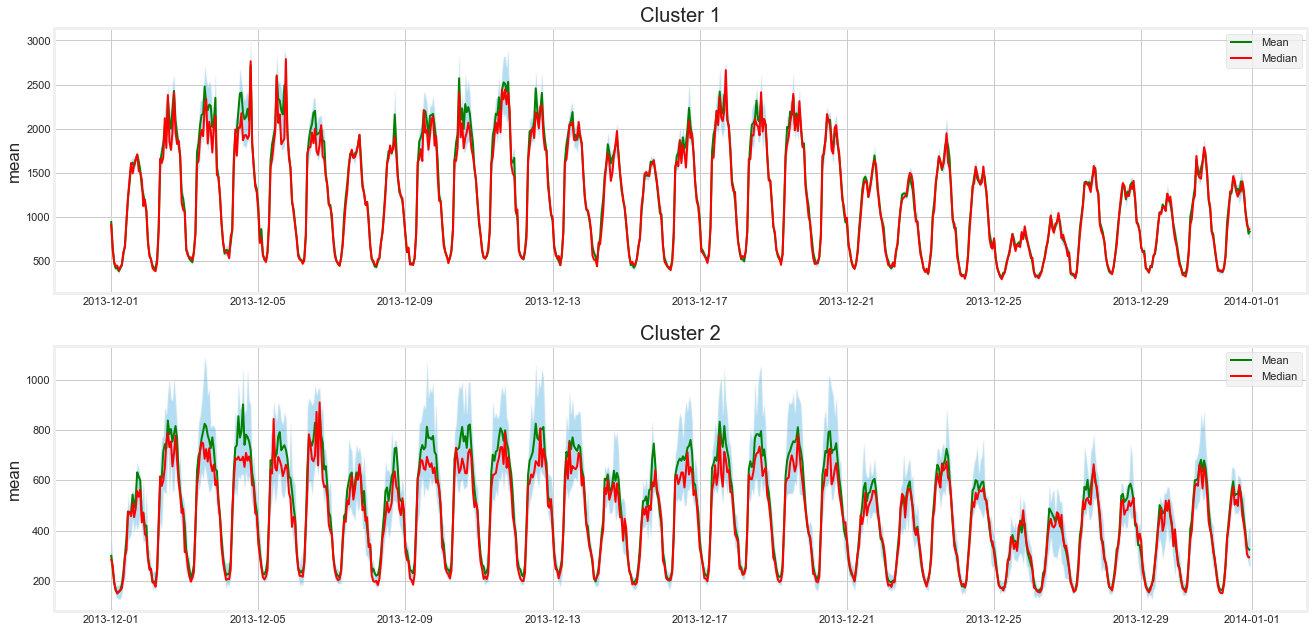

In [53]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(2, 1, 1)
make_graph(EDkM_1, "Cluster 1")
plt.subplot(2, 1, 2)
make_graph(EDkM_2, "Cluster 2")
plt.show()

In [54]:
EDkM_1_pivot = EDkM_1.pivot(index='DateTime', columns='GRID', values='InternetActivity')
EDkM_2_pivot = EDkM_2.pivot(index='DateTime', columns='GRID', values='InternetActivity')

from sklearn import preprocessing

EDkM_1_array = EDkM_1_pivot.values
min_max_scaler = preprocessing.MinMaxScaler()
EDkM_1_scaled = min_max_scaler.fit_transform(EDkM_1_array)
EDkM_1_normalised = pd.DataFrame(EDkM_1_scaled, columns=EDkM_1_pivot.columns.values)
EDkM_1_normalised.index = EDkM_1_pivot.index
EDkM_1_normalised = EDkM_1_normalised.reset_index()
EDkM_1_normalised = pd.melt(EDkM_1_normalised, id_vars='DateTime', var_name='GRID', value_name='NormalisedInternetActivity')
EDkM_1_normalised['assigned_cluster'] = 1

EDkM_2_array = EDkM_2_pivot.values
min_max_scaler = preprocessing.MinMaxScaler()
EDkM_2_scaled = min_max_scaler.fit_transform(EDkM_2_array)
EDkM_2_normalised = pd.DataFrame(EDkM_2_scaled, columns=EDkM_2_pivot.columns.values)
EDkM_2_normalised.index = EDkM_2_pivot.index
EDkM_2_normalised = EDkM_2_normalised.reset_index()
EDkM_2_normalised = pd.melt(EDkM_2_normalised, id_vars='DateTime', var_name='GRID', value_name='NormalisedInternetActivity')
EDkM_2_normalised['assigned_cluster'] = 2
EDkM_2_normalised


DateTime  GRID  NormalisedInternetActivity  assigned_cluster
0    2013-12-01 00:00:00  2854                    0.253839                 2
1    2013-12-01 01:00:00  2854                    0.208531                 2
2    2013-12-01 02:00:00  2854                    0.073164                 2
3    2013-12-01 03:00:00  2854                    0.008846                 2
4    2013-12-01 04:00:00  2854                    0.008268                 2
...                  ...   ...                         ...               ...
5947 2013-12-31 19:00:00  5551                    0.281676                 2
5948 2013-12-31 20:00:00  5551                    0.349819                 2
5949 2013-12-31 21:00:00  5551                    0.229184                 2
5950 2013-12-31 22:00:00  5551                    0.182860                 2
5951 2013-12-31 23:00:00  5551                    0.155269                 2

[5952 rows x 4 columns]

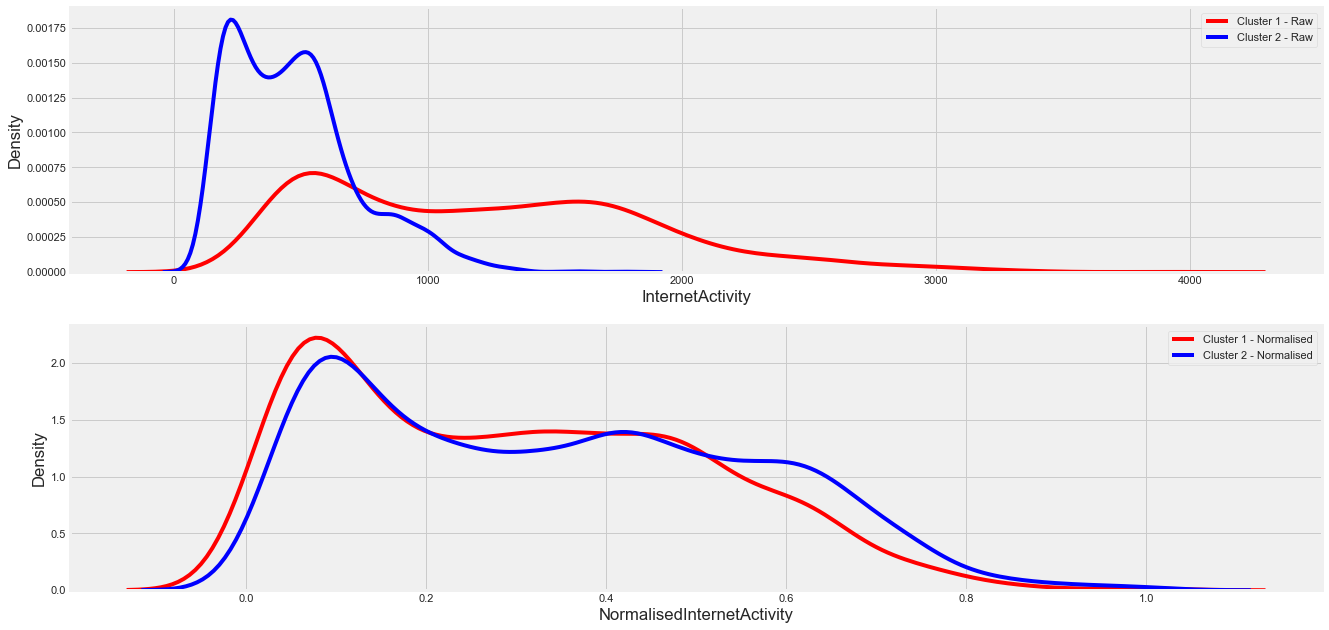

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(2,1,1)
hist = sns.distplot(EDkM_1['InternetActivity'], hist=False, color='red', label='Cluster 1 - Raw')
hist = sns.distplot(EDkM_2['InternetActivity'], hist=False, color='blue', label='Cluster 2 - Raw')
plt.legend()

plt.subplot(2,1,2)
hist = sns.distplot(EDkM_1_normalised['NormalisedInternetActivity'], hist=False, color='red',label='Cluster 1 - Normalised')
hist = sns.distplot(EDkM_2_normalised['NormalisedInternetActivity'], hist=False, color='blue', label='Cluster 2 - Normalised')
plt.legend()
plt.show()

I'm happy with the normalisation of these two distributions. 

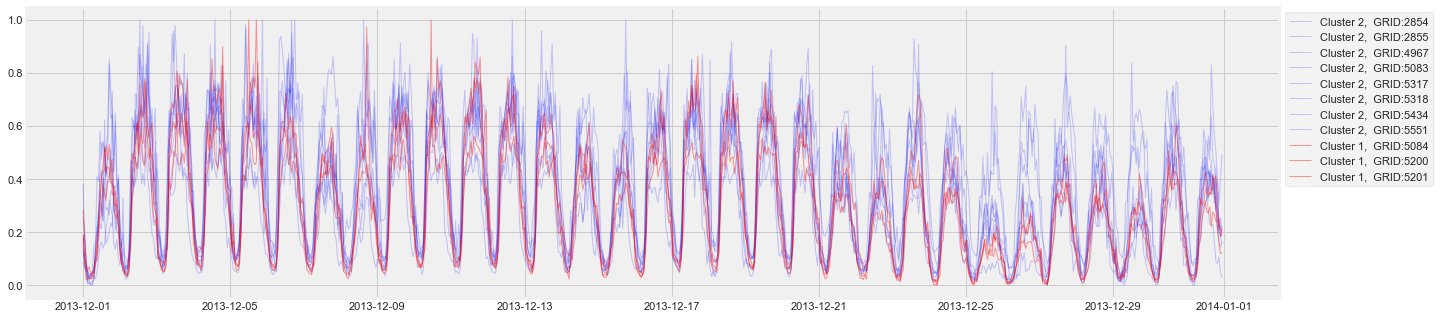

In [56]:
fig, ax = plt.subplots(figsize=(20, 5))
fig.patch.set_facecolor('#FFFFFF')

for GRID in EDkM_2_normalised['GRID'].unique():
    data = EDkM_2_normalised[EDkM_2_normalised['GRID'] == GRID]
    ax.plot(data['DateTime'], 
            data['NormalisedInternetActivity'], 
            color='blue',
            linewidth=1,
            label=f'Cluster 2,  GRID:{GRID}',
            alpha=0.2)

for GRID in EDkM_1_normalised['GRID'].unique():
    data = EDkM_1_normalised[EDkM_1_normalised['GRID'] == GRID]
    ax.plot(data['DateTime'], 
            data['NormalisedInternetActivity'], 
            color='red',
            linewidth=1,
            label=f'Cluster 1,  GRID:{GRID}',
            alpha=0.4)
    
ax.legend(bbox_to_anchor=(1, 1))    
plt.show()

These look relatively similar from the overlays, but to get a clearer picture I'll compare aggregations of these two normalised groups to see how the patterns compare. 

In [57]:
def make_agg_df_normalised(input_dataframe: pd.DataFrame):
    EDkM_agg = pd.DataFrame()
    EDkM_agg['iqr_lower'] = input_dataframe.groupby('DateTime').NormalisedInternetActivity.quantile(0.25) 
    EDkM_agg['iqr_upper'] = input_dataframe.groupby('DateTime').NormalisedInternetActivity.quantile(0.75)
    EDkM_agg['median'] = input_dataframe.groupby('DateTime').NormalisedInternetActivity.median()
    EDkM_agg['mean'] = input_dataframe.groupby('DateTime').NormalisedInternetActivity.mean()
    EDkM_agg['min'] = input_dataframe.groupby('DateTime').NormalisedInternetActivity.min()
    EDkM_agg['max'] = input_dataframe.groupby('DateTime').NormalisedInternetActivity.max()
    
    return EDkM_agg

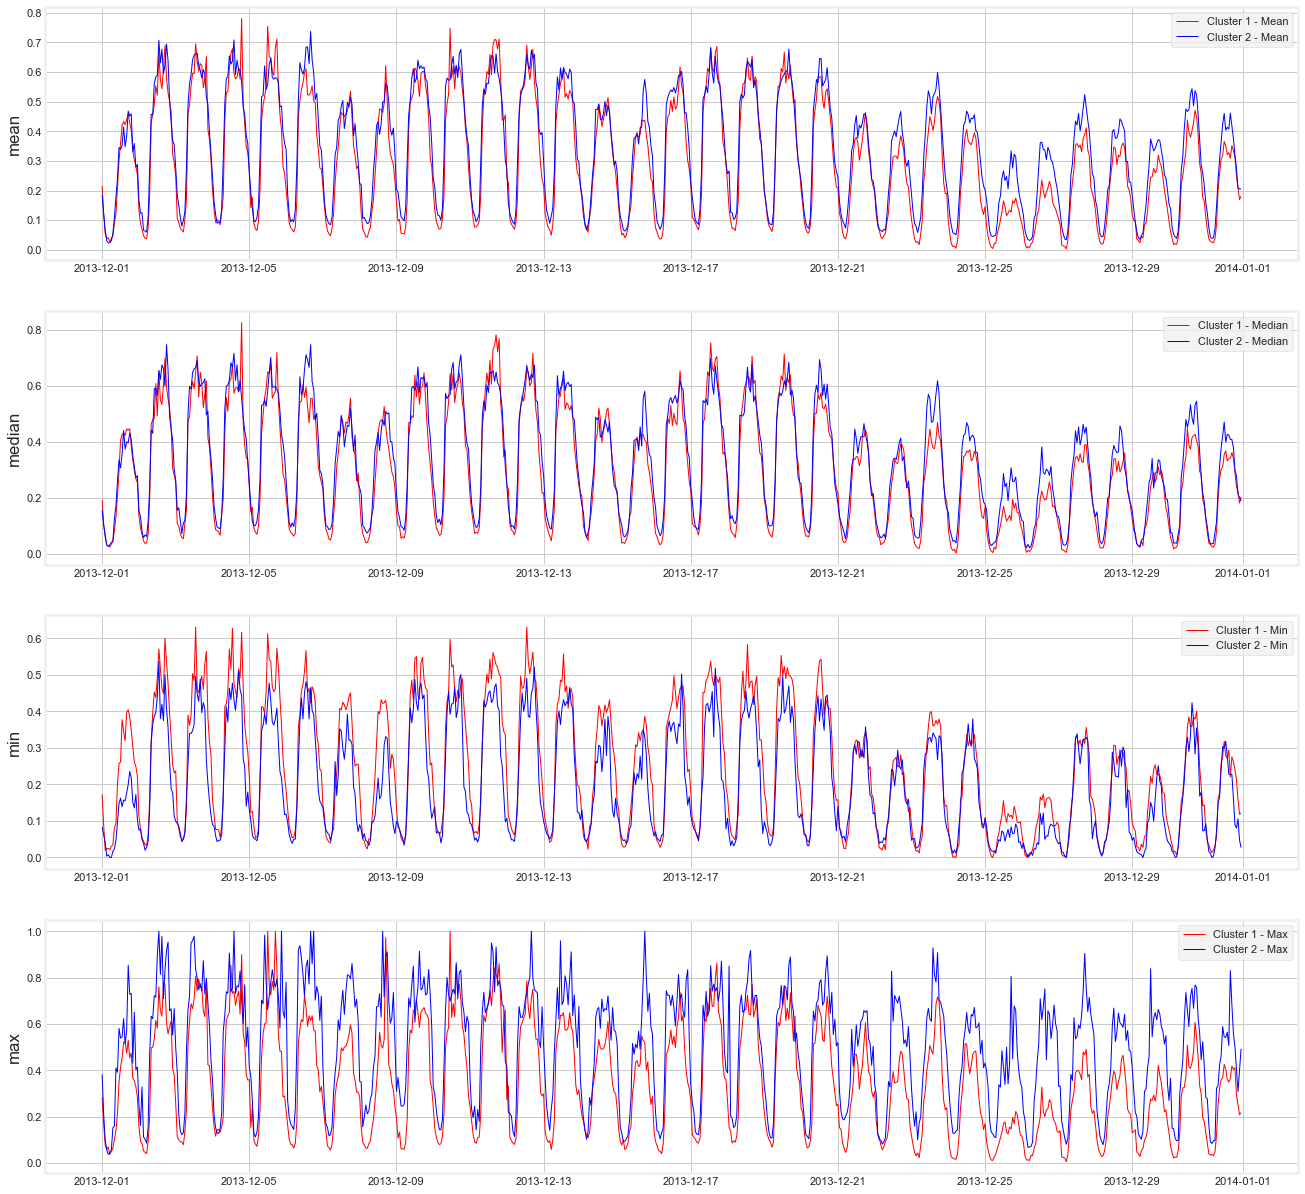

In [58]:
Cluster1_norm_agg = make_agg_df_normalised(EDkM_1_normalised)
Cluster2_norm_agg = make_agg_df_normalised(EDkM_2_normalised)


fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(4, 1, 1)
ax = sns.lineplot(Cluster1_norm_agg.index.values, Cluster1_norm_agg['mean'], color='red', label='Cluster 1 - Mean', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['mean'], color='blue', label='Cluster 2 - Mean', linewidth=1) 
ax.set_facecolor('#FFFFFF')
plt.subplot(4, 1, 2)
ax = sns.lineplot(Cluster1_norm_agg.index.values, Cluster1_norm_agg['median'], color='red', label='Cluster 1 - Median', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['median'], color='blue', label='Cluster 2 - Median', linewidth=1)
ax.set_facecolor('#FFFFFF')
plt.subplot(4, 1, 3)
ax = sns.lineplot(Cluster1_norm_agg.index.values, Cluster1_norm_agg['min'], color='red', label='Cluster 1 - Min', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['min'], color='blue', label='Cluster 2 - Min', linewidth=1)
ax.set_facecolor('#FFFFFF')
plt.subplot(4, 1, 4)
ax = sns.lineplot(Cluster1_norm_agg.index.values, Cluster1_norm_agg['max'], color='red', label='Cluster 1 - Max', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['max'], color='blue', label='Cluster 2 - Max', linewidth=1)
ax.set_facecolor('#FFFFFF')

plt.show()

A comparison of the aggregations of this data, shows a very similar tend over the general working week (data from 1st December to 21st December) - with Cluster 2 having a generally broader profile of data (lower min, higher max in general). 

Interestingly, Cluster 2 has a higher max value over the Christmas period (25th December - 1st January) - remaining similar to the max reached over the start of the month (1st December - 21st December). 

Based on the similarity of this data, I am tempted to class these as sub-clusters of the same cluster, as key differences seem be primarly the magnitude of internet activity (Cluster 1 showing around double that of Cluster 2) and holiday period patterning (Internet activity within Cluster 2 remaining steady, whilst a drop off in activity is seen for Cluster 1 over the holiday period). This could suggest distinct business districts within the Trentino area. 

I'm also interested in comparing the normalised data from cluster 2 and cluster 3 - as these both seem to have relatively steady internet activity over the holiday period, so it would be interesting to see how they compare when normalised. 

## Analysing Clusters 2 and 3

In [59]:
EDkM_3_pivot = EDkM_3.pivot(index='DateTime', columns='GRID', values='InternetActivity')

EDkM_3_array = EDkM_3_pivot.values
min_max_scaler = preprocessing.MinMaxScaler()
EDkM_3_scaled = min_max_scaler.fit_transform(EDkM_3_array)
EDkM_3_normalised = pd.DataFrame(EDkM_3_scaled, columns=EDkM_3_pivot.columns.values)
EDkM_3_normalised.index = EDkM_3_pivot.index
EDkM_3_normalised = EDkM_3_normalised.reset_index()
EDkM_3_normalised = pd.melt(EDkM_3_normalised, id_vars='DateTime', var_name='GRID', value_name='NormalisedInternetActivity')

EDkM_3_normalised

DateTime   GRID  NormalisedInternetActivity
0     2013-12-01 00:00:00   2265                    0.568958
1     2013-12-01 01:00:00   2265                    0.282836
2     2013-12-01 02:00:00   2265                    0.236333
3     2013-12-01 03:00:00   2265                    0.165951
4     2013-12-01 04:00:00   2265                    0.143094
...                   ...    ...                         ...
72163 2013-12-31 19:00:00  10746                    0.871903
72164 2013-12-31 20:00:00  10746                    0.984859
72165 2013-12-31 21:00:00  10746                    0.912532
72166 2013-12-31 22:00:00  10746                    0.915743
72167 2013-12-31 23:00:00  10746                    0.958805

[72168 rows x 3 columns]

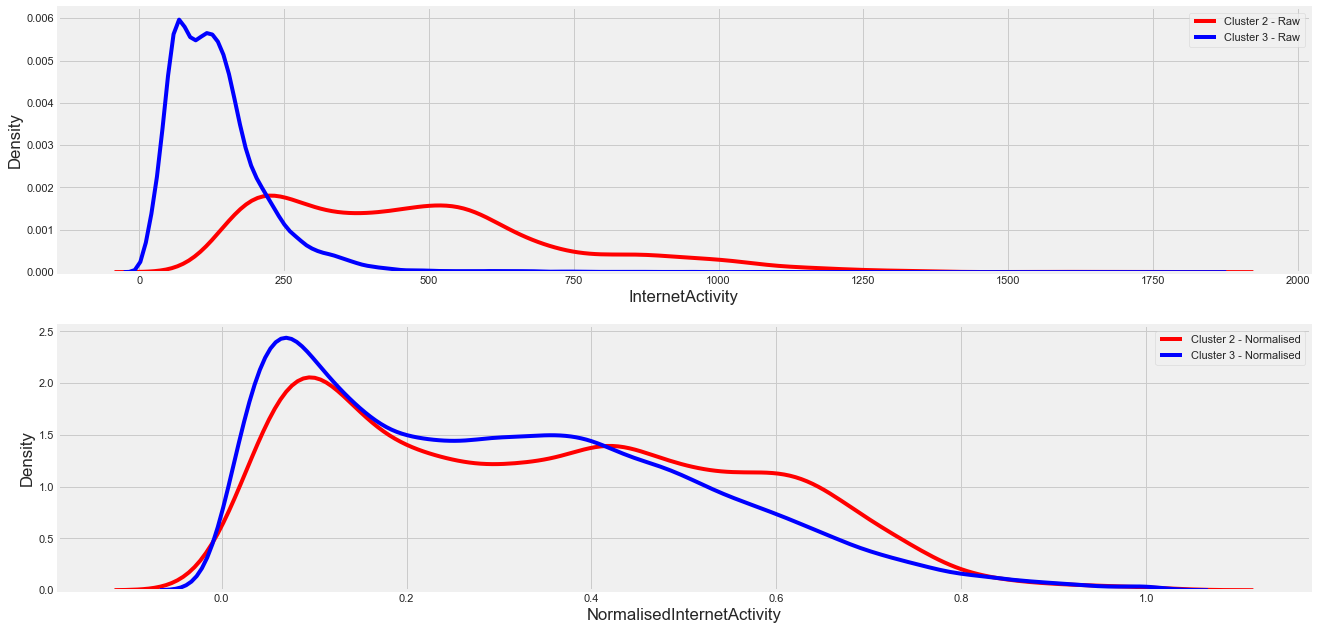

In [60]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('#FFFFFF')
plt.subplot(2,1,1)
hist = sns.distplot(EDkM_2['InternetActivity'], hist=False, color='red', label='Cluster 2 - Raw')
hist = sns.distplot(EDkM_3['InternetActivity'], hist=False, color='blue', label='Cluster 3 - Raw')
ax.set_facecolor('#FFFFFF')

plt.legend()
plt.subplot(2,1,2)
hist = sns.distplot(EDkM_2_normalised['NormalisedInternetActivity'], hist=False, color='red', label='Cluster 2 - Normalised')
hist = sns.distplot(EDkM_3_normalised['NormalisedInternetActivity'], hist=False, color='blue', label='Cluster 3 - Normalised')
ax.set_facecolor('#FFFFFF')

plt.legend()
plt.show()

Again, I'm happy with the normalisation occuring here. 

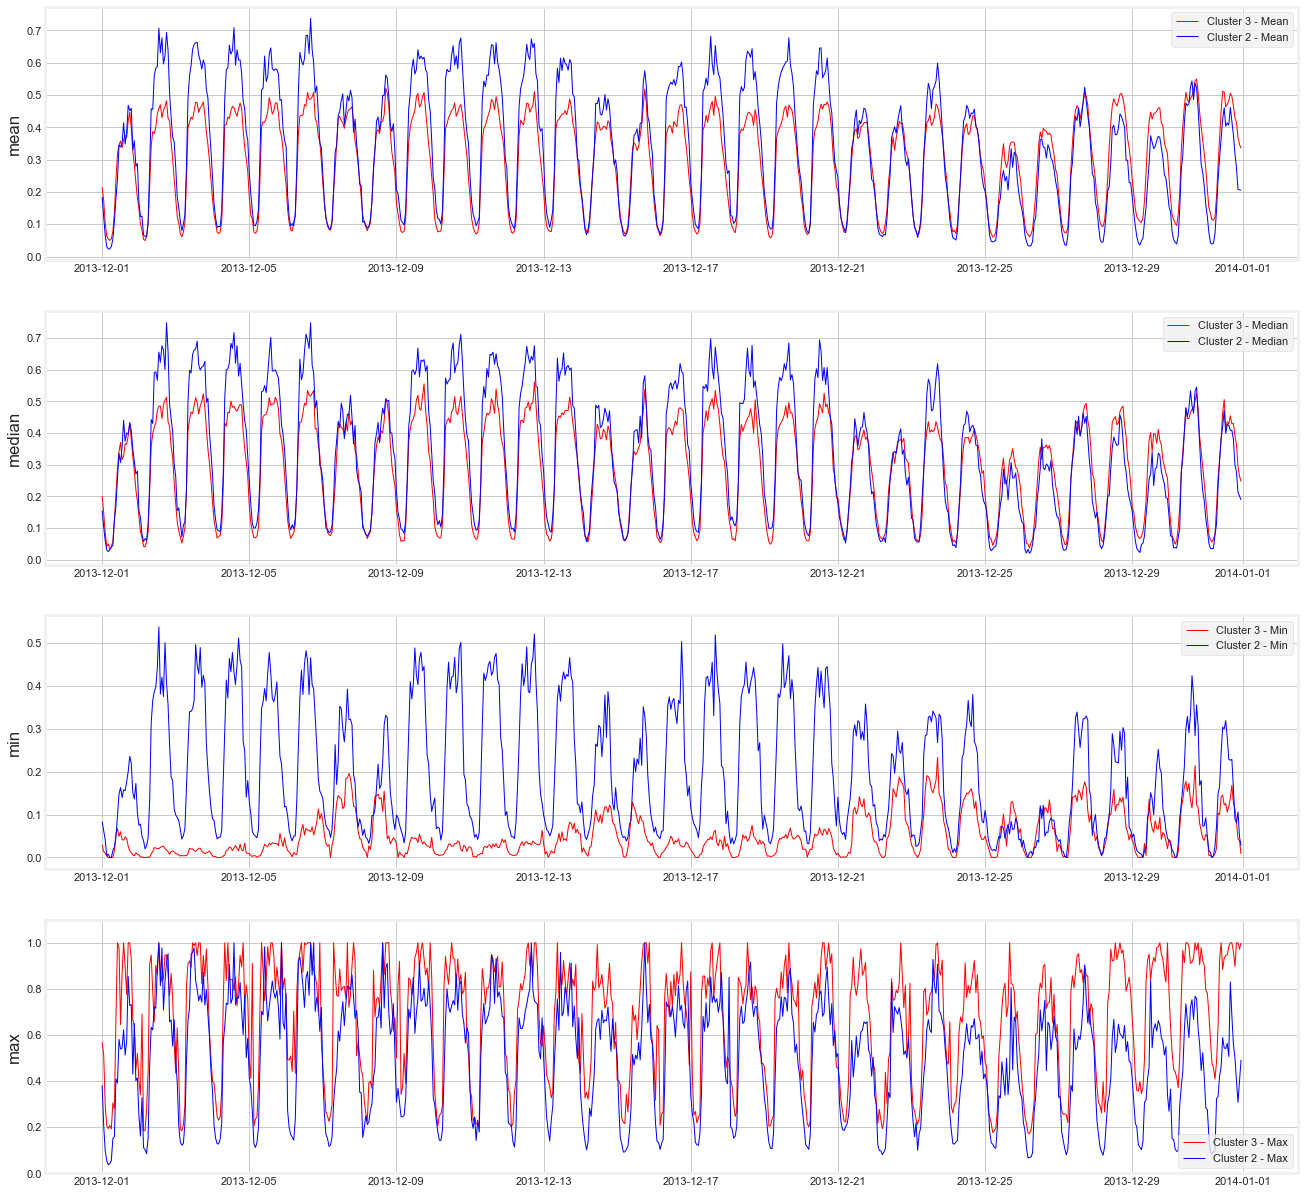

In [61]:
Cluster3_norm_agg = make_agg_df_normalised(EDkM_3_normalised)

fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(4, 1, 1)
ax = sns.lineplot(Cluster3_norm_agg.index.values, Cluster3_norm_agg['mean'], color='red', label='Cluster 3 - Mean', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['mean'], color='blue', label='Cluster 2 - Mean', linewidth=1) 
ax.set_facecolor('#FFFFFF')

plt.subplot(4, 1, 2)
ax = sns.lineplot(Cluster3_norm_agg.index.values, Cluster3_norm_agg['median'], color='red', label='Cluster 3 - Median', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['median'], color='blue', label='Cluster 2 - Median', linewidth=1)
ax.set_facecolor('#FFFFFF')

plt.subplot(4, 1, 3)
ax = sns.lineplot(Cluster3_norm_agg.index.values, Cluster3_norm_agg['min'], color='red', label='Cluster 3 - Min', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['min'], color='blue', label='Cluster 2 - Min', linewidth=1)
ax.set_facecolor('#FFFFFF')

plt.subplot(4, 1, 4)
ax = sns.lineplot(Cluster3_norm_agg.index.values, Cluster3_norm_agg['max'], color='red', label='Cluster 3 - Max', linewidth=1) 
ax = sns.lineplot(Cluster2_norm_agg.index.values, Cluster2_norm_agg['max'], color='blue', label='Cluster 2 - Max', linewidth=1)
ax.set_facecolor('#FFFFFF')
plt.ylim(0, 1.1)

plt.show()

Cluster 2 generally has a greater level of change in average and median activity over time, with similar troughs to Cluster 3 but generally taller peaks observed. Cluster two also has a much more distinctive trend for the minimum over time; however, this likely reflects the smaller dataset in this pool (8 compared to 97 in cluster 3).  
Acitivity over the bank holiday days for both of these clusters is reduced. 

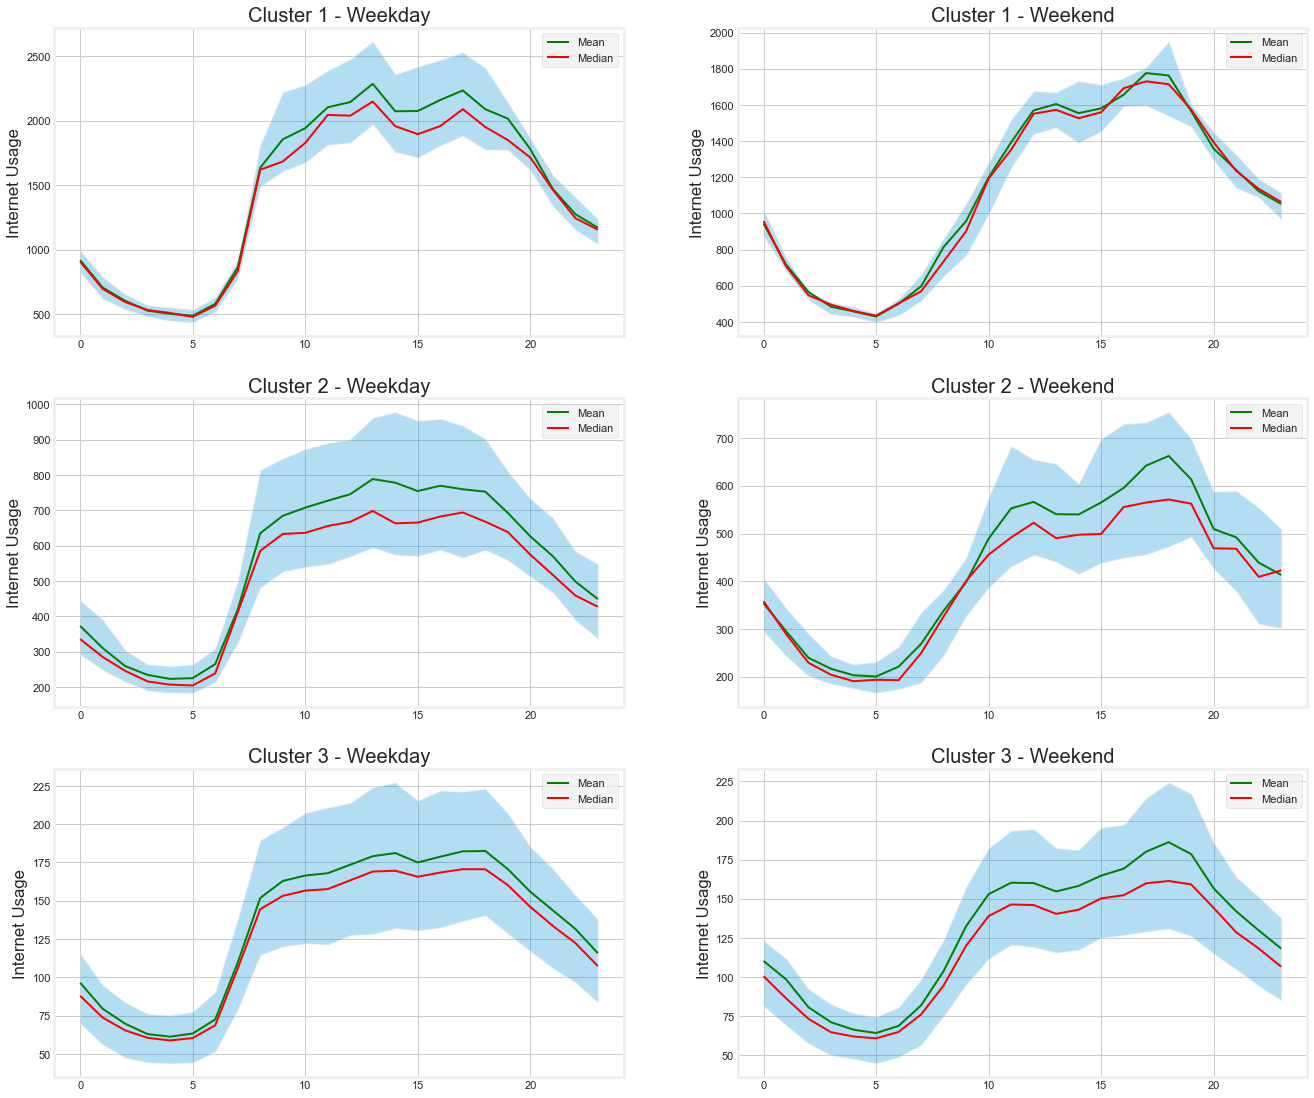

In [264]:
fig, ax = plt.subplots(figsize=(20, 18))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(3, 2, 1)
create_time_graph(EDkM_1, weekendflag=0, title="Cluster 1 - Weekday")
plt.subplot(3, 2, 2)
create_time_graph(EDkM_1, weekendflag=1, title="Cluster 1 - Weekend")
plt.subplot(3, 2, 3)
create_time_graph(EDkM_2, weekendflag=0, title="Cluster 2 - Weekday")
plt.subplot(3, 2, 4)
create_time_graph(EDkM_2, weekendflag=1, title="Cluster 2 - Weekend")
plt.subplot(3, 2, 5)
create_time_graph(EDkM_3, weekendflag=0, title="Cluster 3 - Weekday")
plt.subplot(3, 2, 6)
create_time_graph(EDkM_3, weekendflag=1, title="Cluster 3 - Weekend")
plt.show()

In [262]:
agg1 = make_week_time_agg(EDkM_1)
agg2 = make_week_time_agg(EDkM_2)
agg3 = make_week_time_agg(EDkM_3)

agg1_we = make_week_time_agg(EDkM_1, 1)
agg2_we = make_week_time_agg(EDkM_2, 1)
agg3_we = make_week_time_agg(EDkM_3, 1)


agg1_xm = make_week_time_agg(EDkM_1, 1, beforechristmas=False, afterchristmas=True)
agg2_xm = make_week_time_agg(EDkM_2, 1, beforechristmas=False, afterchristmas=True)
agg3_xm = make_week_time_agg(EDkM_3, 1, beforechristmas=False, afterchristmas=True)


MaxAverages_group123 = pd.DataFrame()
MaxAverages_group123['Cluster'] = [1,2,3]
MaxAverages_group123['Weekday'] = [agg1['mean'].max(), agg2['mean'].max(), agg3['mean'].max()]
MaxAverages_group123['Weekend'] = [agg1_we['mean'].max(), agg2_we['mean'].max(), agg3_we['mean'].max()]
MaxAverages_group123['%Change'] = (MaxAverages_group123['Weekend'] - MaxAverages_group123['Weekday']) / MaxAverages_group123['Weekday'] * 100
MaxAverages_group123['Christmas'] = [agg1_xm['mean'].max(), agg2_xm['mean'].max(), agg3_xm['mean'].max()]
MaxAverages_group123['%ChristmasChange'] = (MaxAverages_group123['Christmas'] - MaxAverages_group123['Weekday']) / MaxAverages_group123['Weekday'] * 100
MaxAverages_group123

Cluster      Weekday      Weekend    %Change    Christmas  %ChristmasChange
0        1  2285.600163  1776.329295 -22.281713  1456.510963        -36.274464
1        2   788.395433   662.526805 -15.965165   595.135745        -24.513040
2        3   182.501207   186.131530   1.989205   178.732088         -2.065257

## Analysing Cluster 4

Cluster 4 had similar trends to cluster 0, with some increase in activity over the weekend and holiday period, but a much higher magnitude of activity in general. I'd like to take a look at the daily trends and weekday vs weekend comparisons to see if this gives more information. 

In [271]:
agg4 = make_week_time_agg(EDkM_4)
agg4_we = make_week_time_agg(EDkM_4, 1)
agg4_xm = make_week_time_agg(EDkM_4, 1, beforechristmas=False, afterchristmas=True)

MaxAverages_group4 = pd.DataFrame()
MaxAverages_group4['Cluster'] = [4]
MaxAverages_group4['Weekday'] = [agg4['mean'].max()]
MaxAverages_group4['Weekend'] = [agg4_we['mean'].max()]
MaxAverages_group4['%Change'] = (MaxAverages_group4['Weekend'] - MaxAverages_group4['Weekday']) / MaxAverages_group4['Weekday'] * 100
MaxAverages_group4['Christmas'] = [agg4_xm['mean'].max()]
MaxAverages_group4['%ChristmasChange'] = (MaxAverages_group4['Christmas'] - MaxAverages_group4['Weekday']) / MaxAverages_group4['Weekday'] * 100
MaxAverages_group4

Cluster    Weekday    Weekend    %Change  Christmas  %ChristmasChange
0        4  45.684906  54.361809  18.992932  57.053852         24.885563

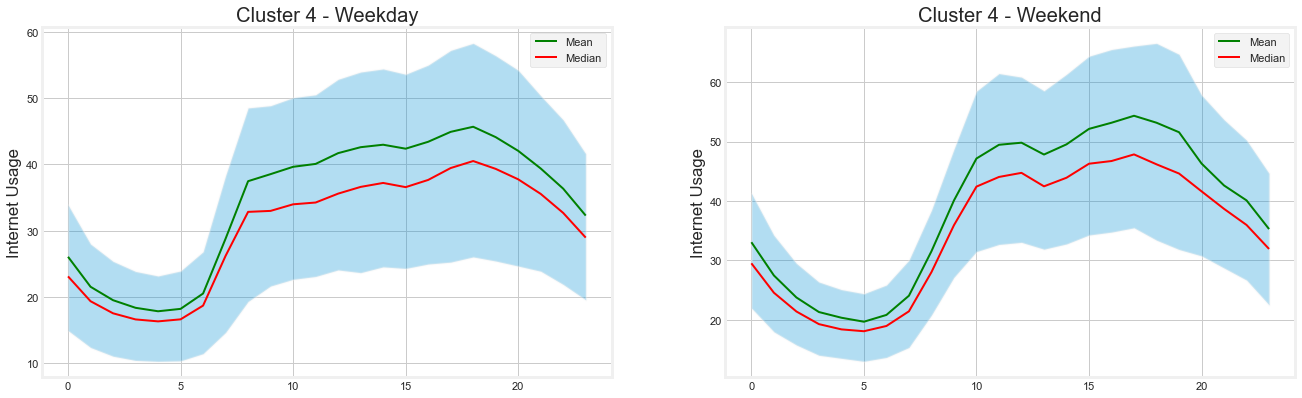

In [276]:
fig, ax = plt.subplots(figsize=(20, 6))
fig.patch.set_facecolor('#FFFFFF')

plt.subplot(1, 2, 1)
create_time_graph(EDkM_4, weekendflag=0, title="Cluster 4 - Weekday")
plt.subplot(1, 2, 2)
create_time_graph(EDkM_4, weekendflag=1, title="Cluster 4 - Weekend")

plt.show()

Theres a small increase in activity (~20%) at the weekend, and a slightly narrower profile on the weekends, which I think is consistent with this being another residential area - similar to cluster 0 - but with a higher population, and as such higher level of internet activity observed.

## Looking at the Spacial Distribution of the Clusters

I'm now really interested to see how these clusters are distributed across Trentino. I've never worked with geospacial data before, so it's quite an exciting challenge to get my teeth into! 

I'll first print out the clusters I have generated into the list of GRID references. 

In [62]:
import pandas as pd

ClusteredGrid = pd.DataFrame(EDkM['assigned_cluster'])
ClusteredGrid['secondary_cluster'] = pd.DataFrame(Cluster0_unpivot['assigned_cluster'])

In [63]:
def cluster_id(row):
    return f"{str(row['assigned_cluster'])}.{str(row['secondary_cluster'])}"

ClusteredGrid['cluster_value'] = ClusteredGrid.apply(cluster_id, axis=1)
ClusteredGrid = ClusteredGrid.drop(['assigned_cluster', 'secondary_cluster'], axis=1)
ClusteredGrid = ClusteredGrid.reset_index()

I'll now import the geojson of the Trentino area create a dataframe from this information. 

In [64]:
import geojson
with open('1_Trentino_Grid/trentino-grid.geojson') as f:
    gj = geojson.load(f)
features = gj['features']

In [65]:
features[0]

{"geometry": {"coordinates": [[[10.914622, 45.682007], [10.927456, 45.681791], [10.927147, 45.672795], [10.914315, 45.673011], [10.914622, 45.682007]]], "type": "Polygon"}, "id": 0, "properties": {"cellId": 38}, "type": "Feature"}

In [66]:
df_features = pd.DataFrame(features)
df_features.head()

type  id                                           geometry  \
0  Feature   0  {'type': 'Polygon', 'coordinates': [[[10.91462...   
1  Feature   1  {'type': 'Polygon', 'coordinates': [[[10.92745...   
2  Feature   2  {'type': 'Polygon', 'coordinates': [[[10.94029...   
3  Feature   3  {'type': 'Polygon', 'coordinates': [[[10.90209...   
4  Feature   4  {'type': 'Polygon', 'coordinates': [[[10.91492...   

        properties  
0   {'cellId': 38}  
1   {'cellId': 39}  
2   {'cellId': 40}  
3  {'cellId': 154}  
4  {'cellId': 155}

The dataframe has the GRID id (or cell id) listed within a json string in the properties column. I'll now extract that information, so I can merge my cluster values to this dataframe.

In [67]:
import json

def get_cell_id(row):
    return row['properties']['cellId']#.values()  
    
df_features['cell_id'] = df_features.apply(get_cell_id, axis=1)
df_features = df_features.drop('properties', axis=1)
df_features

type    id                                           geometry  \
0     Feature     0  {'type': 'Polygon', 'coordinates': [[[10.91462...   
1     Feature     1  {'type': 'Polygon', 'coordinates': [[[10.92745...   
2     Feature     2  {'type': 'Polygon', 'coordinates': [[[10.94029...   
3     Feature     3  {'type': 'Polygon', 'coordinates': [[[10.90209...   
4     Feature     4  {'type': 'Polygon', 'coordinates': [[[10.91492...   
...       ...   ...                                                ...   
6570  Feature  6570  {'type': 'Polygon', 'coordinates': [[[11.80474...   
6571  Feature  6571  {'type': 'Polygon', 'coordinates': [[[11.81777...   
6572  Feature  6572  {'type': 'Polygon', 'coordinates': [[[11.79218...   
6573  Feature  6573  {'type': 'Polygon', 'coordinates': [[[11.80521...   
6574  Feature  6574  {'type': 'Polygon', 'coordinates': [[[11.81823...   

      cell_id  
0          38  
1          39  
2          40  
3         154  
4         155  
...       ...  
6570    11336  
6571    11337  
6572    11452  
6573    11453  
6574    11454  

[6575 rows x 4 columns]

Before I merge the two data frames, I want to know how many GRIDs we're missing clustering information for. 

In [68]:
missing_GRIDS = df_features.cell_id[~df_features['cell_id'].isin(ClusteredGrid['GRID'])]
missing_GRIDS

62        619
63        620
88        737
114       854
115       855
        ...  
6468    10698
6508    10857
6510    10859
6511    10860
6512    10861
Name: cell_id, Length: 316, dtype: int64

As there are a reasonable number of GRIDs that are missing from the internet activity data, I'll need to make sure I assign these a 'blank' colour when I specify fill colours for my clusters. 

I'll now merge my cluster values onto the geospacial data. 

In [69]:
df_features_merged = df_features.merge(ClusteredGrid, how='left', left_on='cell_id', right_on='GRID')
df_features_merged['cluster_value'].isna().sum()

316

In [70]:
df_features_merged.drop(['GRID'], axis=1)

type    id                                           geometry  \
0     Feature     0  {'type': 'Polygon', 'coordinates': [[[10.91462...   
1     Feature     1  {'type': 'Polygon', 'coordinates': [[[10.92745...   
2     Feature     2  {'type': 'Polygon', 'coordinates': [[[10.94029...   
3     Feature     3  {'type': 'Polygon', 'coordinates': [[[10.90209...   
4     Feature     4  {'type': 'Polygon', 'coordinates': [[[10.91492...   
...       ...   ...                                                ...   
6570  Feature  6570  {'type': 'Polygon', 'coordinates': [[[11.80474...   
6571  Feature  6571  {'type': 'Polygon', 'coordinates': [[[11.81777...   
6572  Feature  6572  {'type': 'Polygon', 'coordinates': [[[11.79218...   
6573  Feature  6573  {'type': 'Polygon', 'coordinates': [[[11.80521...   
6574  Feature  6574  {'type': 'Polygon', 'coordinates': [[[11.81823...   

      cell_id cluster_value  
0          38           0.5  
1          39           0.2  
2          40           0.5  
3         154           4.0  
4         155           4.0  
...       ...           ...  
6570    11336           0.2  
6571    11337           0.2  
6572    11452           4.0  
6573    11453           4.0  
6574    11454           4.0  

[6575 rows x 5 columns]

### Creating a filled map with all clusters coloured

My first step now is to try to make a .geojson file which has 'fill' information related to the cluster value for each GRID.

In [71]:
colors = np.array([[0.0, '#00338D'], [0.2, '#2272FF'], [0.1,'#66CCFF'],[0.3,'#92D050'],[0.5,'#009A44'],[0.4,'#FFFF99'],[1.0,'#800000'],[2.0,'#C40000'],[3.0,'#FF0D0D'],[4.0,'#EAAA00']])
colors_df = pd.DataFrame(data=colors, columns=['cluster_value', 'fill'])
colors_df

cluster_value     fill
0           0.0  #00338D
1           0.2  #2272FF
2           0.1  #66CCFF
3           0.3  #92D050
4           0.5  #009A44
5           0.4  #FFFF99
6           1.0  #800000
7           2.0  #C40000
8           3.0  #FF0D0D
9           4.0  #EAAA00

In [72]:
df_features_fill = df_features_merged.merge(colors_df, how='left', left_on='cluster_value', right_on='cluster_value')
df_features_fill['stroke-width'] = 0.1
df_features_fill['stroke-opacity'] = 0.1
df_features_fill['fill-opacity']=1.0
df_features_fill['fill'] = df_features_fill['fill'].replace(np.nan, '#BEBEBE', regex=True)
df_features_fill

type    id                                           geometry  \
0     Feature     0  {'type': 'Polygon', 'coordinates': [[[10.91462...   
1     Feature     1  {'type': 'Polygon', 'coordinates': [[[10.92745...   
2     Feature     2  {'type': 'Polygon', 'coordinates': [[[10.94029...   
3     Feature     3  {'type': 'Polygon', 'coordinates': [[[10.90209...   
4     Feature     4  {'type': 'Polygon', 'coordinates': [[[10.91492...   
...       ...   ...                                                ...   
6570  Feature  6570  {'type': 'Polygon', 'coordinates': [[[11.80474...   
6571  Feature  6571  {'type': 'Polygon', 'coordinates': [[[11.81777...   
6572  Feature  6572  {'type': 'Polygon', 'coordinates': [[[11.79218...   
6573  Feature  6573  {'type': 'Polygon', 'coordinates': [[[11.80521...   
6574  Feature  6574  {'type': 'Polygon', 'coordinates': [[[11.81823...   

      cell_id     GRID cluster_value     fill  stroke-width  stroke-opacity  \
0          38     38.0           0.5  #009A44           0.1             0.1   
1          39     39.0           0.2  #2272FF           0.1             0.1   
2          40     40.0           0.5  #009A44           0.1             0.1   
3         154    154.0           4.0  #EAAA00           0.1             0.1   
4         155    155.0           4.0  #EAAA00           0.1             0.1   
...       ...      ...           ...      ...           ...             ...   
6570    11336  11336.0           0.2  #2272FF           0.1             0.1   
6571    11337  11337.0           0.2  #2272FF           0.1             0.1   
6572    11452  11452.0           4.0  #EAAA00           0.1             0.1   
6573    11453  11453.0           4.0  #EAAA00           0.1             0.1   
6574    11454  11454.0           4.0  #EAAA00           0.1             0.1   

      fill-opacity  
0              1.0  
1              1.0  
2              1.0  
3              1.0  
4              1.0  
...            ...  
6570           1.0  
6571           1.0  
6572           1.0  
6573           1.0  
6574           1.0  

[6575 rows x 10 columns]

As the geojson format requires 'fill', 'stroke width', 'stroke-opacity' and 'fill-opacity' to be nested within a 'style' section, I'll parse these into json format within a style column.

In [73]:
def style_json(row):
    row_json = row[['fill','stroke-width', 'stroke-opacity', 'fill-opacity']].to_json()
    return json.JSONDecoder().decode(row_json)

df_features_fill['style'] = df_features_fill.apply(style_json, axis=1)
df_features_fill

type    id                                           geometry  \
0     Feature     0  {'type': 'Polygon', 'coordinates': [[[10.91462...   
1     Feature     1  {'type': 'Polygon', 'coordinates': [[[10.92745...   
2     Feature     2  {'type': 'Polygon', 'coordinates': [[[10.94029...   
3     Feature     3  {'type': 'Polygon', 'coordinates': [[[10.90209...   
4     Feature     4  {'type': 'Polygon', 'coordinates': [[[10.91492...   
...       ...   ...                                                ...   
6570  Feature  6570  {'type': 'Polygon', 'coordinates': [[[11.80474...   
6571  Feature  6571  {'type': 'Polygon', 'coordinates': [[[11.81777...   
6572  Feature  6572  {'type': 'Polygon', 'coordinates': [[[11.79218...   
6573  Feature  6573  {'type': 'Polygon', 'coordinates': [[[11.80521...   
6574  Feature  6574  {'type': 'Polygon', 'coordinates': [[[11.81823...   

      cell_id     GRID cluster_value     fill  stroke-width  stroke-opacity  \
0          38     38.0           0.5  #009A44           0.1             0.1   
1          39     39.0           0.2  #2272FF           0.1             0.1   
2          40     40.0           0.5  #009A44           0.1             0.1   
3         154    154.0           4.0  #EAAA00           0.1             0.1   
4         155    155.0           4.0  #EAAA00           0.1             0.1   
...       ...      ...           ...      ...           ...             ...   
6570    11336  11336.0           0.2  #2272FF           0.1             0.1   
6571    11337  11337.0           0.2  #2272FF           0.1             0.1   
6572    11452  11452.0           4.0  #EAAA00           0.1             0.1   
6573    11453  11453.0           4.0  #EAAA00           0.1             0.1   
6574    11454  11454.0           4.0  #EAAA00           0.1             0.1   

      fill-opacity                                              style  
0              1.0  {'fill': '#009A44', 'stroke-width': 0.1, 'stro...  
1              1.0  {'fill': '#2272FF', 'stroke-width': 0.1, 'stro...  
2              1.0  {'fill': '#009A44', 'stroke-width': 0.1, 'stro...  
3              1.0  {'fill': '#EAAA00', 'stroke-width': 0.1, 'stro...  
4              1.0  {'fill': '#EAAA00', 'stroke-width': 0.1, 'stro...  
...            ...                                                ...  
6570           1.0  {'fill': '#2272FF', 'stroke-width': 0.1, 'stro...  
6571           1.0  {'fill': '#2272FF', 'stroke-width': 0.1, 'stro...  
6572           1.0  {'fill': '#EAAA00', 'stroke-width': 0.1, 'stro...  
6573           1.0  {'fill': '#EAAA00', 'stroke-width': 0.1, 'stro...  
6574           1.0  {'fill': '#EAAA00', 'stroke-width': 0.1, 'stro...  

[6575 rows x 11 columns]

I will now print this dataframe to a .geojson format. 

In [74]:
from geojson import Feature, FeatureCollection, dump

new_features = []

def row_to_feature(row):
     return Feature(geometry =row['geometry'], properties=row['style'])

with open('AllClusters.geojson', 'w') as filehandle:
    for i in df_features_fill.index.values:
        filehandle.write('%s,\n' % Feature(geometry=df_features_fill.iloc[i]['geometry'], properties=df_features_fill.iloc[i]['style']))

I struggled to assigned the new_features file to a FeatureCollection - so in order to get this to work I have wrapped the contents of the resulting .txt file with:


"{"crs": {"type": "name", "properties": {"name": "urn:ogc:def:crs:EPSG::4326"}}, "type": "FeatureCollection", "features": [          [TEXT FILE CONTENTS]          ]}"

This was then pushed to GitHub to view the .geojson output. 

I'm hoping to return to understand how to create the FeatureCollection dynamically, but as this is a timeboxed exercise I felt it pertinent to move on.

### Creating GEOJSON files highlighting individual clusters

I noow want to create these .geojson maps highlighting individual groupings of clusters, for the presentation. 

In [75]:
colors_0 = np.array([[0.0, '#00338D'], [0.2, '#2272FF'], [0.1,'#66CCFF'],[0.3,'#92D050'],[0.5,'#009A44'],[0.4,'#FFFF99'],[1.0,'#BEBEBE'],[2.0,'#BEBEBE'],[3.0,'#BEBEBE'],[4.0,'#BEBEBE']])
colors_000201 = np.array([[0.0, '#00338D'], [0.2, '#2272FF'], [0.1,'#66CCFF'],[0.3,'#BEBEBE'],[0.5,'#BEBEBE'],[0.4,'#BEBEBE'],[1.0,'#BEBEBE'],[2.0,'#BEBEBE'],[3.0,'#BEBEBE'],[4.0,'#BEBEBE']])
colors_0305 = np.array([[0.0, '#BEBEBE'], [0.2, '#BEBEBE'], [0.1,'#BEBEBE'],[0.3,'#92D050'],[0.5,'#009A44'],[0.4,'#BEBEBE'],[1.0,'#BEBEBE'],[2.0,'#BEBEBE'],[3.0,'#BEBEBE'],[4.0,'#BEBEBE']])
colors_04 = np.array([[0.0, '#BEBEBE'], [0.2, '#BEBEBE'], [0.1,'#BEBEBE'],[0.3,'#BEBEBE'],[0.5,'#BEBEBE'],[0.4,'#FFFF99'],[1.0,'#BEBEBE'],[2.0,'#BEBEBE'],[3.0,'#BEBEBE'],[4.0,'#BEBEBE']])
colors_123 = np.array([[0.0, '#BEBEBE'], [0.2, '#BEBEBE'], [0.1,'#BEBEBE'],[0.3,'#BEBEBE'],[0.5,'#BEBEBE'],[0.4,'#BEBEBE'],[1.0,'#800000'],[2.0,'#C40000'],[3.0,'#FF0D0D'],[4.0,'#BEBEBE']])
colors_4 = np.array([[0.0, '#BEBEBE'], [0.2, '#BEBEBE'], [0.1,'#BEBEBE'],[0.3,'#BEBEBE'],[0.5,'#BEBEBE'],[0.4,'#BEBEBE'],[1.0,'#BEBEBE'],[2.0,'#BEBEBE'],[3.0,'#BEBEBE'],[4.0,'#EAAA00']])

In [76]:
def create_features(colors_dataframe: pd.DataFrame, features_dataframe: pd.DataFrame, strokewidth: float=0.1, strokeopacity: float=0.1, fillopacity: float=1.0):
    colors_df = pd.DataFrame(data=colors_dataframe, columns=['cluster_value', 'fill'])
    features_dataframe['stroke-width'] = 0.1
    features_dataframe['stroke-opacity'] = 0.1
    features_dataframe['fill-opacity']=1.0
    colormerge = features_dataframe.merge(colors_df, how='left', left_on='cluster_value', right_on='cluster_value')
    colormerge['fill'] = colormerge['fill'].replace(np.nan, '#BEBEBE', regex=True)
    colormerge['style'] = colormerge.apply(style_json, axis=1)
    return colormerge

In [77]:
df_features_cluster0 = create_features(colors_0, df_features_merged)
df_features_cluster000201 = create_features(colors_000201, df_features_merged)
df_features_cluster0305 = create_features(colors_0305, df_features_merged)
df_features_cluster04 = create_features(colors_04, df_features_merged)
df_features_cluster123 = create_features(colors_123, df_features_merged)
df_features_cluster4 = create_features(colors_4, df_features_merged)

In [78]:
# Cluster 0 - All sub clusters
with open('Cluster0.geojson', 'w') as filehandle:
    for i in df_features_cluster0.index.values:
        filehandle.write('%s,\n' % Feature(geometry=df_features_cluster0.iloc[i]['geometry'], properties=df_features_cluster0.iloc[i]['style']))
        
# Sub Clusters 00, 01 & 02
with open('Cluster000201.geojson', 'w') as filehandle:
    for i in df_features_cluster000201.index.values:
        filehandle.write('%s,\n' % Feature(geometry=df_features_cluster000201.iloc[i]['geometry'], properties=df_features_cluster000201.iloc[i]['style']))
        
# Sub Clusters 03 & 05 
with open('Cluster0305.geojson', 'w') as filehandle:
    for i in df_features_cluster0305.index.values:
        filehandle.write('%s,\n' % Feature(geometry=df_features_cluster0305.iloc[i]['geometry'], properties=df_features_cluster0305.iloc[i]['style']))
        
# Sub Cluster 04
with open('Cluster04.geojson', 'w') as filehandle:
    for i in df_features_cluster04.index.values:
        filehandle.write('%s,\n' % Feature(geometry=df_features_cluster04.iloc[i]['geometry'], properties=df_features_cluster04.iloc[i]['style']))

# Clusters 1, 2 & 3
with open('Cluster123.geojson', 'w') as filehandle:
    for i in df_features_cluster123.index.values:
        filehandle.write('%s,\n' % Feature(geometry=df_features_cluster123.iloc[i]['geometry'], properties=df_features_cluster123.iloc[i]['style']))

# Cluster 4
with open('Cluster4.geojson', 'w') as filehandle:
    for i in df_features_cluster4.index.values:
        filehandle.write('%s,\n' % Feature(geometry=df_features_cluster4.iloc[i]['geometry'], properties=df_features_cluster4.iloc[i]['style']))
        


These files can be viewed within my GitHub repository [here](https://github.com/natalie-stephenson/GeoJson)

I'm really happy with how these clusters have grouped spacially. And I think I've finally figured out the strange patterns observed in cluster 0.4. 

This one had really puzzled me, with the 'business hour' daily peak but the large spikes at the weekends and over Christmas. Having seen it on a map overlayed with the Trentino area, I think this relates to ski resorts!! 

It wasn't tracking business hours, but daylight hours. The sharp drop off observed as people leave the ski resort and return to the near by towns/cities to stay. 

## Future Work

With more time, I'd like to expand this analysis to look at how these clusters correlate with the other data we have, looking at the trends in the electical current flowing through these GRIDs align to internet usage, and whether differences in  air quality correlates to the regions I've picked out to be 'high population' and 'low population'. 